# Title: 'Tree-based ML for insurance pricing'
## Based on : Book Interpretation Tools for ML methods and 'Tree-based ML for insurance pricing'  on Github by 'Roel Henckaerts, Marie-Pier Côté, Katrien Antonio and Roel Verbelen'

# Structure of the notebook

* [I - DATA](#four)
    + [4.1 DATA](#four-one)
    + [4.2 Claim frequency](#four-two)
    + [4.3 Claim severity](#four-three)

* [II - Interpretation tools](#five)
    + [5.1 Feature importance](#five-one)
    + [5.2 Partial dependence](#five-two)


* [I - Actuarial tree](#four)
    + [4.1 MTPL data](#four-one)
    + [4.2 Claim frequency](#four-two)
    + [4.3 Claim severity](#four-three)

* [II - Interpretation tools](#five)
    + [5.1 Feature importance](#five-one)
    + [5.2 Partial dependence](#five-two)


In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from collections import defaultdict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from scipy.special import gamma
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay

from sklearn.tree import plot_tree
# instead of contructing them from scratch we import them sklearn.metrics
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## DATA


In [2]:
mtpl_orig = pd.read_csv('Assignment.csv')
df2 = pd.read_excel('inspost.xls')
# Merge df1 and df2 based on the common column 'CODPOSS'
mtpl = mtpl_orig.merge(df2, left_on='CODPOSS', right_on='CODPOSS')

mtpl

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,INS,COMMUNE,LAT,LONG
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110,21004,BRUSSEL,50.833333,4.350000
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110,21004,BRUSSEL,50.833333,4.350000
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66,21004,BRUSSEL,50.833333,4.350000
3,62,1000,1.000000,0.000000,0,0.000000,0.000000,>10,Female,Petrol,Once,Private,No,No,MTPL+,<66,21004,BRUSSEL,50.833333,4.350000
4,41,1000,1.000000,0.000000,1,1.000000,62.419590,6-10,Female,Petrol,Monthly,Private,No,No,MTPL,66-110,21004,BRUSSEL,50.833333,4.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,76,3320,1.000000,0.000000,0,0.000000,0.000000,6-10,Male,Petrol,Once,Private,No,No,MTPL,<66,24041,HOEGAARDEN,50.766667,4.883333
163653,42,4770,1.000000,0.000000,1,1.000000,516.337423,>10,Male,Gasoil,Once,Private,No,No,MTPL,<66,63001,AMEL,50.350000,6.166667
163654,48,4770,1.000000,0.000000,0,0.000000,0.000000,>10,Male,Petrol,Monthly,Private,No,No,MTPL,<66,63001,AMEL,50.350000,6.166667
163655,27,4770,1.000000,0.000000,0,0.000000,0.000000,6-10,Male,Petrol,Twice,Private,No,No,MTPL,<66,63001,AMEL,50.350000,6.166667


In [3]:
# describe 

mtpl.describe()
print (mtpl.describe(include = 'object'))

        agecar    sexp   fuelc   split     usec  fleetc  sportc  coverp  \
count   163657  163657  163657  163657   163657  163657  163657  163657   
unique       4       2       2       4        2       2       2       3   
top       6-10    Male  Petrol    Once  Private      No      No    MTPL   
freq     67151  120434  113210   81479   155652  158428  162145   95409   

        powerc    COMMUNE  
count   163657     163657  
unique       3        583  
top        <66  CHARLEROI  
freq    119809       5038  


In [4]:

# Rename columns to lowercase
mtpl.columns = [col.lower() for col in mtpl.columns]

# Redefine split 
replacement_dict = {'Once': 1, 'Twice': 2, 'Thrice': 3, 'Monthly': 12}

# Replace values in the 'col1' column using the dictionary
mtpl['split'] = mtpl['split'].replace(replacement_dict)

# Calculate mean and frequency
m = mtpl['nbrtotc'].mean()
freq = mtpl['nbrtotc'].sum() / mtpl['duree'].sum()

# Print dimensions
print(mtpl.shape)

(163657, 20)


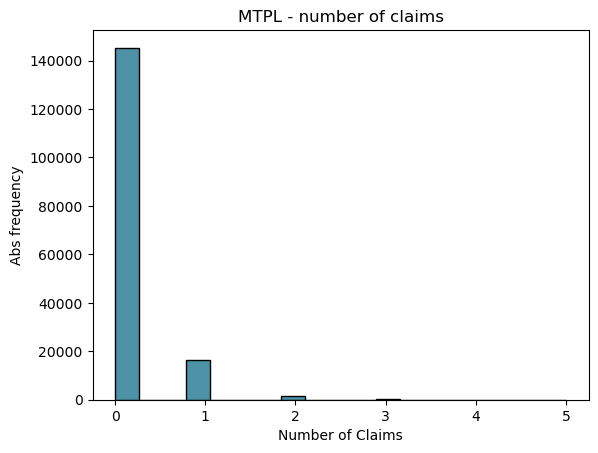

In [5]:
# Visualization
KULbg = "#116E8A"
g = sns.histplot(mtpl['nbrtotc'], color=KULbg)
g.set(xlabel='Number of Claims', ylabel='Abs frequency', title='MTPL - number of claims')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:416: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


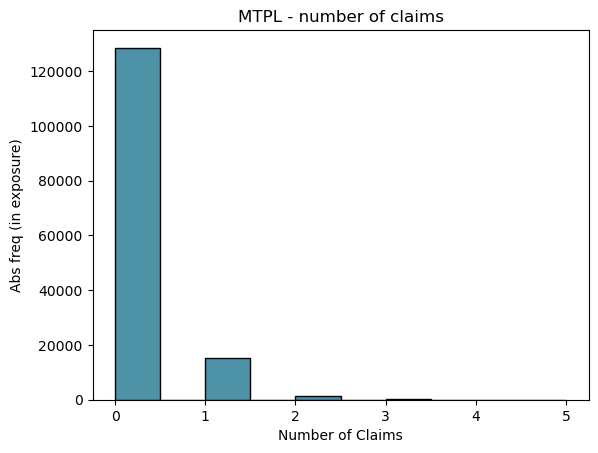

In [6]:
g = sns.histplot(mtpl, x='nbrtotc', weights='duree', color=KULbg)
g.set(xlabel='Number of Claims', ylabel='Abs freq (in exposure)', title='MTPL - number of claims')
plt.show()

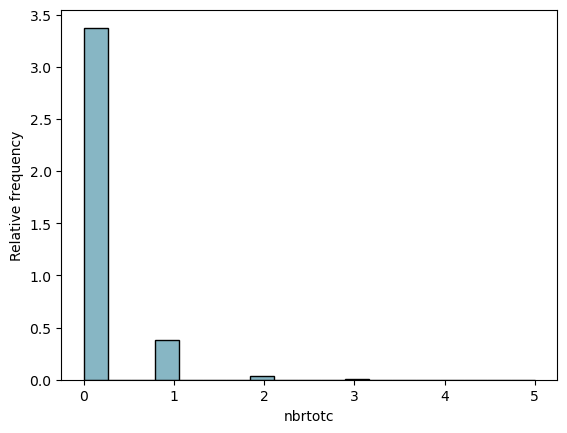

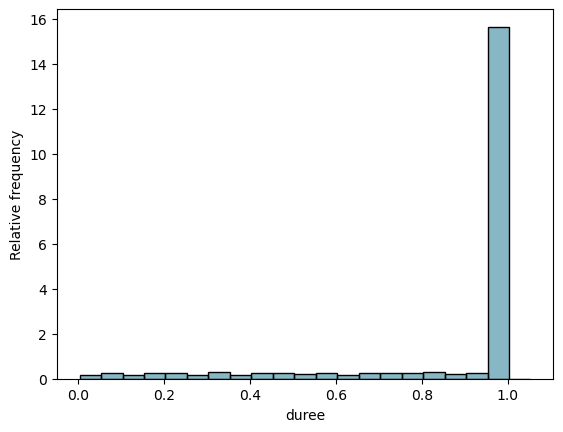

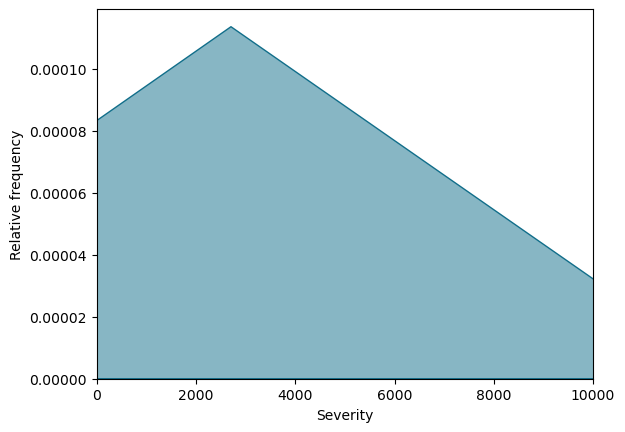

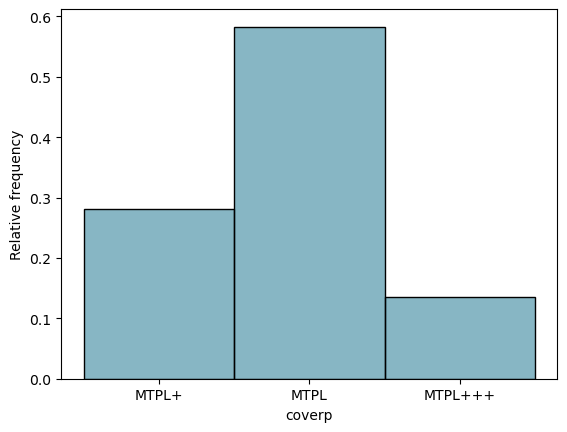

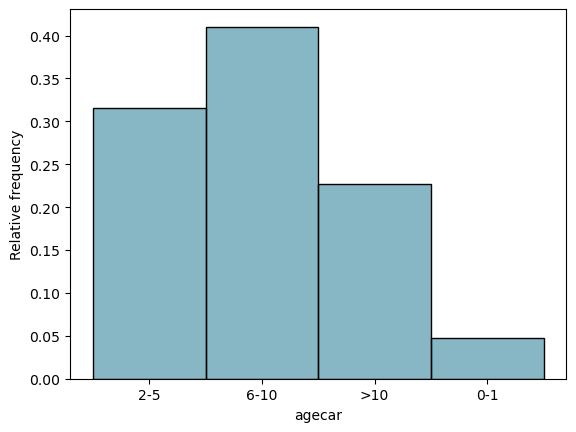

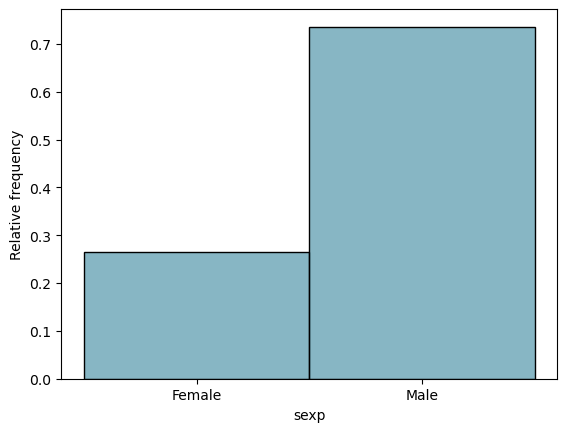

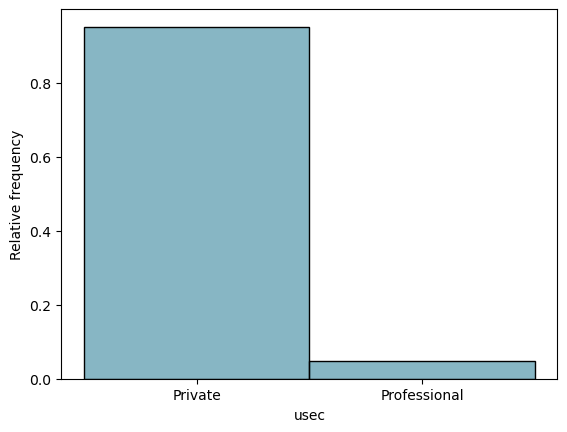

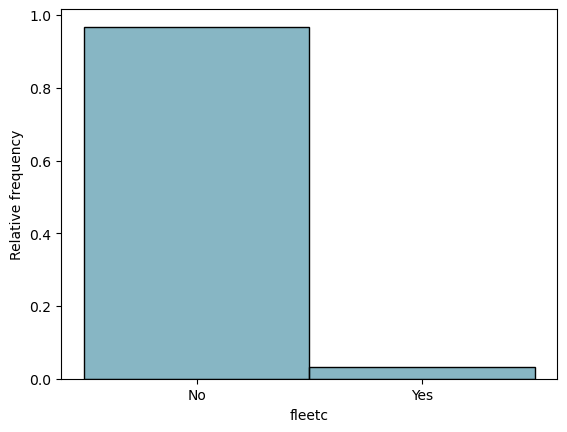

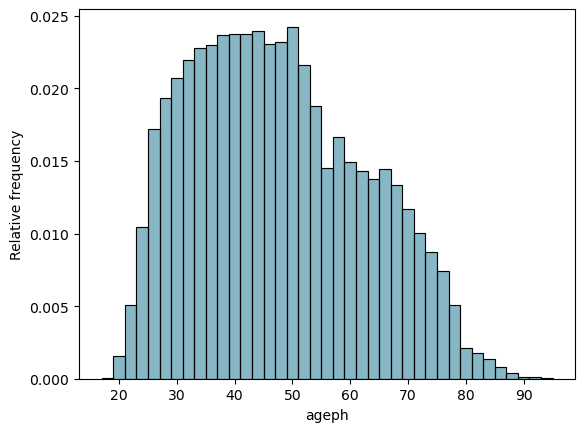

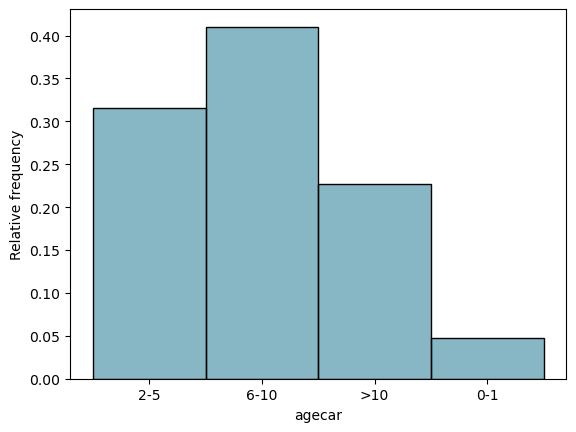

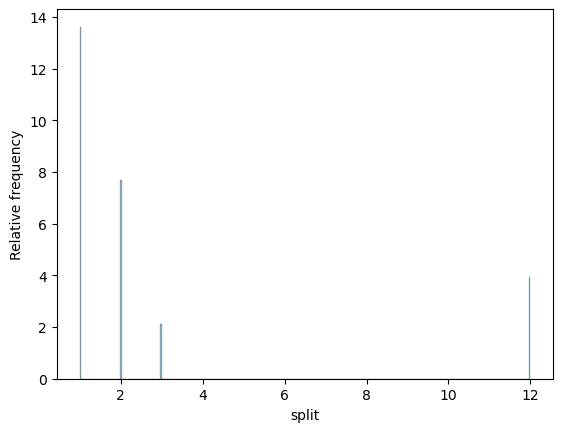

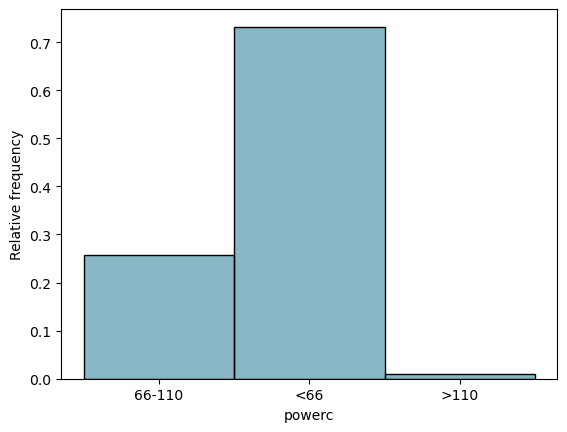

In [7]:
# Wrapper functions
def ggplot_bar(DT, variable, xlab):
    g = sns.histplot(data=DT, x=variable, stat='density', color=KULbg, alpha=0.5)
    g.set(xlabel=xlab, ylabel='Relative frequency')
    plt.show()

def ggplot_hist(DT, variable, xlab, binwidth):
    g = sns.histplot(data=DT, x=variable, binwidth=binwidth, stat='density', color=KULbg, alpha=0.5)
    g.set(xlabel=xlab, ylabel='Relative frequency')
    plt.show()
# Targets: frequency, exposure, and total severity
ggplot_bar(mtpl, 'nbrtotc', 'nbrtotc')
ggplot_hist(mtpl, 'duree', 'duree', 0.05)

mtpl_sev = mtpl[(mtpl['chargtot'] > 0)]# & (mtpl['avg'] <= 81000)]  # Filter data
g = sns.kdeplot(data=mtpl_sev['chargtot'], color=KULbg, fill=True, alpha=0.5)
g.set(xlabel='Severity', ylabel='Relative frequency')
plt.xlim(0, 1e4)
plt.show()

# Bar plots of factor variables
for column in ['coverp', 'agecar', 'sexp', 'usec', 'fleetc']:
    ggplot_bar(mtpl, column, column)

# Histograms of continuous variables
ggplot_hist(mtpl, 'ageph', 'ageph', 2)
ggplot_hist(mtpl, 'agecar', 'agecar', 1)
ggplot_bar(mtpl, 'split', 'split')
ggplot_hist(mtpl, 'powerc', 'powerc', 10)

Our graphs shows that we are modeling integer-valued frequency
data or right-skewed severity data, this motivates the use of loss functions which are not based on the squared error loss.

             ageph   codposs     duree    lnexpo   nbrtotc  nbrtotan  \
ageph     1.000000 -0.029827  0.099901  0.078857 -0.069035 -0.038769   
codposs  -0.029827  1.000000  0.070874  0.061599 -0.017948 -0.010157   
duree     0.099901  0.070874  1.000000  0.913371  0.052203 -0.068061   
lnexpo    0.078857  0.061599  0.913371  1.000000  0.056768 -0.081085   
nbrtotc  -0.069035 -0.017948  0.052203  0.056768  1.000000  0.471175   
nbrtotan -0.038769 -0.010157 -0.068061 -0.081085  0.471175  1.000000   
chargtot -0.010823  0.001296  0.000843  0.002014  0.100368  0.058756   
split    -0.114590 -0.207059 -0.256008 -0.220810  0.016326  0.022017   
ins       0.026376  0.377525  0.018485  0.017844 -0.019480 -0.012680   
lat      -0.052471 -0.150414  0.004351  0.000507  0.010329  0.006249   
long      0.049076 -0.533458 -0.039023 -0.033159 -0.004210 -0.005207   

          chargtot     split       ins       lat      long  
ageph    -0.010823 -0.114590  0.026376 -0.052471  0.049076  
codposs   0.0

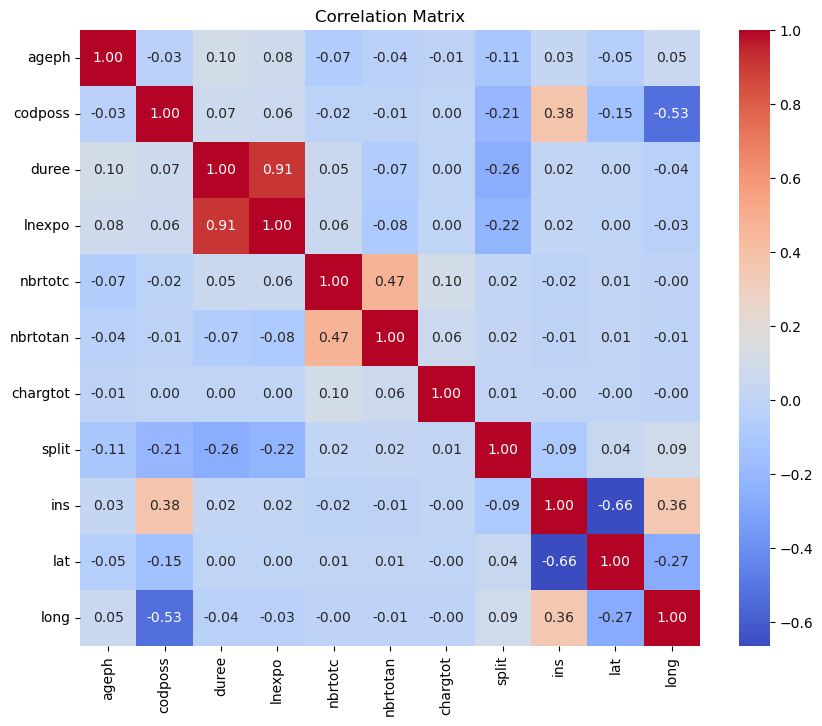

In [8]:
# Assuming df is your DataFrame
correlation_matrix = mtpl.corr()

# Print correlation matrix
print(correlation_matrix)

# Visualize correlation matrix (optional)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Here we can see a high correlation between duree and ln expo so we drop the ln expo collumn in our mtpl.


In [67]:

#Here we can see a high correlation between duree and ln expo so we drop the ln expo collumn in our mtpl.
mtpl = mtpl.drop("lnexpo", axis=1)


KeyError: "['lnexpo'] not found in axis"

In [10]:
mtpl1 = mtpl
mtpl1.columns

Index(['ageph', 'codposs', 'duree', 'nbrtotc', 'nbrtotan', 'chargtot',
       'agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc', 'sportc',
       'coverp', 'powerc', 'ins', 'commune', 'lat', 'long'],
      dtype='object')

In [68]:
mtpl

,ageph,codposs,duree,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,ins,commune,lat,long
0,64,1000,1.000000,0,0.000000,0.000000,1,0,1,1,0,0,0,1,0,21004,85,50.833333,4.350000
1,28,1000,0.046575,1,21.470588,155.974606,2,0,1,2,0,0,0,0,0,21004,85,50.833333,4.350000
2,58,1000,0.402740,0,0.000000,0.000000,3,0,1,3,0,0,0,0,1,21004,85,50.833333,4.350000
3,62,1000,1.000000,0,0.000000,0.000000,3,0,1,1,0,0,0,1,1,21004,85,50.833333,4.350000
4,41,1000,1.000000,1,1.000000,62.419590,2,0,1,12,0,0,0,0,0,21004,85,50.833333,4.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,76,3320,1.000000,0,0.000000,0.000000,2,1,1,1,0,0,0,0,1,24041,232,50.766667,4.883333
163653,42,4770,1.000000,1,1.000000,516.337423,3,1,0,1,0,0,0,0,1,63001,9,50.350000,6.166667
163654,48,4770,1.000000,0,0.000000,0.000000,3,1,1,12,0,0,0,0,1,63001,9,50.350000,6.166667
163655,27,4770,1.000000,0,0.000000,0.000000,2,1,1,2,0,0,0,0,1,63001,9,50.350000,6.166667


### For ML applications, we need to transform all our columns to a numerical input. We will transform our categorical features to integers:

In [11]:
# map string values to integers for certain columns

cats1 = [col for col in mtpl1.columns if mtpl1[col].dtype == 'object']

# Identify columns with strings

label_encoder = LabelEncoder()
for col in cats1:
    mtpl1[col] = label_encoder.fit_transform(mtpl1[col])



#unique_values = mtpl['powerc'].unique()
#print(type(unique_values))
#print(unique_values)
#mltp1['powerc'].unique()
#print (cats1,mtpl.describe(include = 'object'))

mtpl1.dtypes

ageph         int64
codposs       int64
duree       float64
nbrtotc       int64
nbrtotan    float64
chargtot    float64
agecar        int64
sexp          int64
fuelc         int64
split         int64
usec          int64
fleetc        int64
sportc        int64
coverp        int64
powerc        int64
ins           int64
commune       int64
lat         float64
long        float64
dtype: object

 
#### For claim frequency modeling involves count data, typically assumed to be Poisson distributed 
Therefore, an appropriate loss function is the Poisson deviance, defined as follows:
 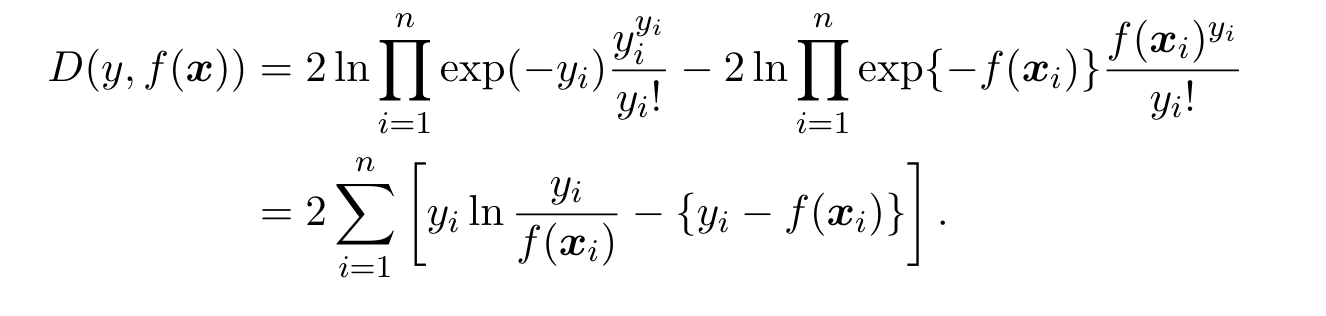
 
#### For severity modeling involves count data, typically assumed to be Gamma distributed 
Right-skewed and long-tailed severity data is typically assumed to be gamma.
The gamma deviance is defined as follows:
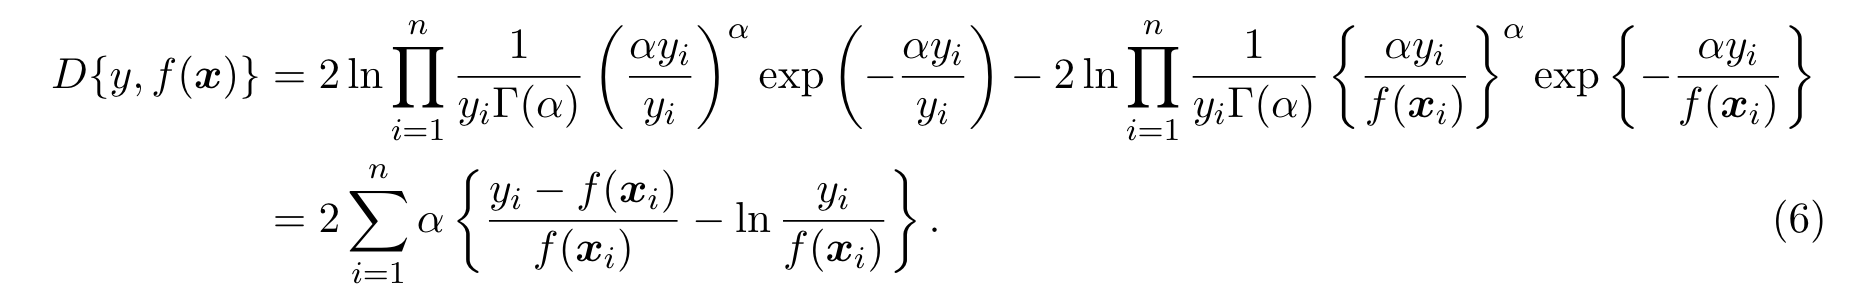

So we can define our loss functions based on the appropriate deviance.

### Deviance loss function for poisson and gamma
When using an exposure-to-risk measure ei
, f(xi) is replaced by ei
·f(xi) such that the exposure
is taken into account in the expected number of claims. This site https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/metrics/_regression.py teaches us how Deviance loss function for poisson and gamma are constructed and how to consider the exposure as weights.


In [12]:
def poisson_deviance1(y_true, y_pred):
    # Poisson distribution
    e = np.exp(-80) ## to avoid y_true==0 for claims
    #pp= (y_true+result) / y_pred
    #for element in pp:
        #print(np.log(element))
        # Calculate the condition
    
    deviance = 2 * np.sum(y_true * np.log(y_true+e / y_pred) - (y_true - y_pred))
    return deviance/len(y_true) 

In [13]:
def gamma_deviance(y_true, y_pred, alpha):
    exposure = X_train['duree']
    e = np.exp(-80)
    n_samples = len(y_true)
    deviance = 2 * np.sum(
        (alpha * ((y_true+e) - y_pred) / y_pred) - np.log((y_true+e) / y_pred)
    )
    return deviance / n_samples

## Frequency modeling


## Claim frequency <a name="four-two"></a>
We start our modeling efforts by building a claim frequency `DecisionTreeRegressor` model for the MTPL dataset. The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) teaches us that there is a `poisson criterion` which uses reduction in Poisson deviance to find splits

In [14]:
X = mtpl1.drop(columns=['nbrtotc','chargtot','duree', 'nbrtotan']) # 
y = mtpl1['nbrtotc']

# claim frequency (nclaims/expo) as target
y_mtpl_freq = np.array(mtpl1.nbrtotc/mtpl1.duree)
# exposure as weights
w_mtpl_freq = np.array(mtpl.duree)
# cols to retain as features
feat_cols = X.columns
# subset the data
X_mtpl_freq = X[feat_cols]
# print the shape
print(X.shape)
# show the features
#X_mtpl_freq
#y_mtpl_freq

(163657, 15)


In [85]:
y_mtpl_freq = len (np.unique(np.array(mtpl1.nbrtotc/mtpl1.duree)))
y_mtpl_freq

551

### Train and test split

In [15]:
# Split data into training and testing sets


X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_mtpl_freq, y_mtpl_freq, test_size=0.2, random_state=42)


## Decision tree FREQ


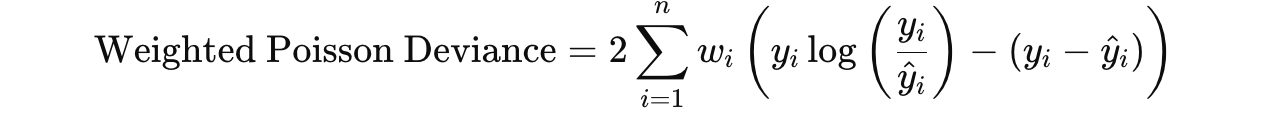

We apply weight so that samples with higher weights have a larger impact on the loss function, while samples with lower weights have a smaller impact. This is because we trust more the samples higher duree.

In [16]:

tree_freq = DecisionTreeRegressor(criterion='poisson', max_depth=10, min_samples_split=10000, min_samples_leaf=5000)
# fit the tree to our target 
tree_freq.fit(X_train_freq, y_train_freq) #, sample_weight=w_mtpl_freq??
# print the tree
tree_freq

DecisionTreeRegressor(criterion='poisson', max_depth=10, min_samples_leaf=5000,
                      min_samples_split=10000)

##### Evaluation on train data

In [17]:
train_predictions = tree_freq.predict(X_train_freq)

# Calculate poisson_deviance on the training set
#exposure = mtpl1['duree']
poisson_dev1 = mean_poisson_deviance(y_train_freq, train_predictions)
print("Training poisson_deviance:", poisson_dev1)


Training poisson_deviance: 0.7885151631196


##### Evaluation on test data

In [18]:
test_Tree_predictions = tree_freq.predict(X_test_freq)

# Calculate poisson_deviance on the training set
#exposure = mtpl1['duree']
poisson_dev1 = mean_poisson_deviance(y_test_freq, test_Tree_predictions)
print("Training poisson_deviance:", poisson_dev1)


Training poisson_deviance: 0.7260394048677671


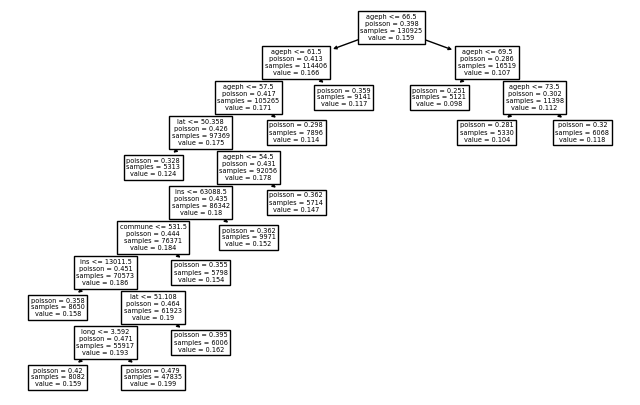

In [19]:
# plot the tree structure
plt.figure(figsize=(8, 5), dpi=100)
plot_tree(tree_freq, feature_names=feat_cols);

## Gradient boosting machine Freq

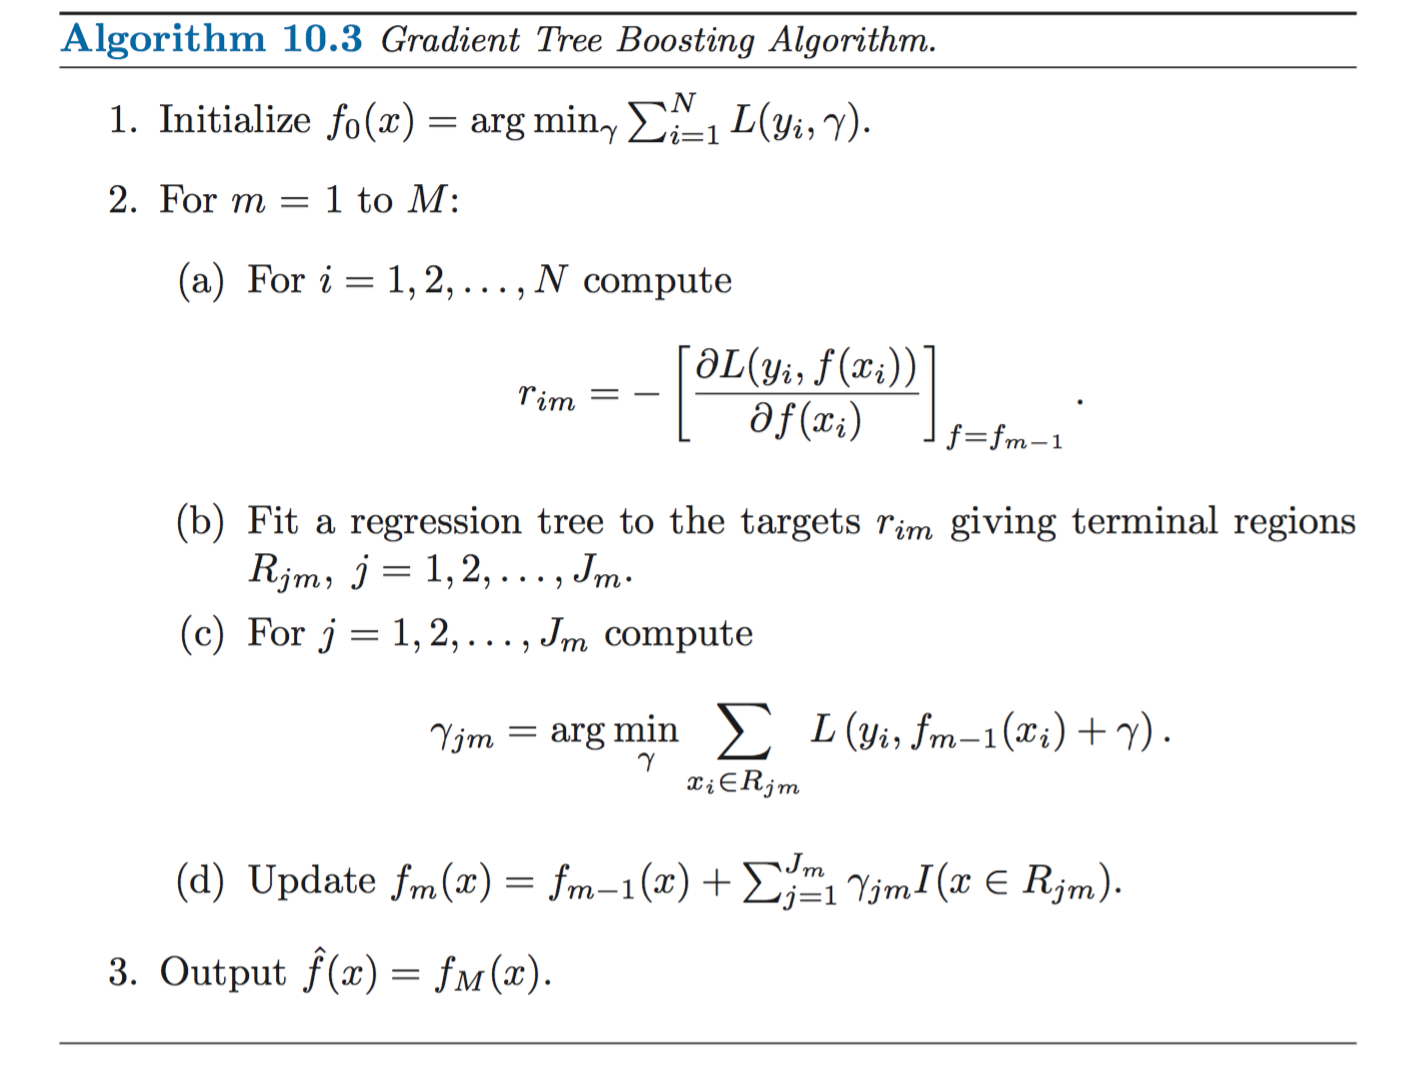


Where N is the number of samples, 𝑀 is the number of iterations and 𝐽𝑚 is the number of terminal regions or size of the tree. Line 3 produces 𝑓̂ (𝑥) which is a 𝐾 sized vector where 𝐾 corresponds to the number of classes.

In libraries like XGBoost the parameter that controls the complexity of the trees is often referred to as:
gamma
We set our gamma to 0.1 aiming to control the complexity of the learned model by penalizing the creation of additional splits in the tree. In this figure it represnts cp (complexity penalty).
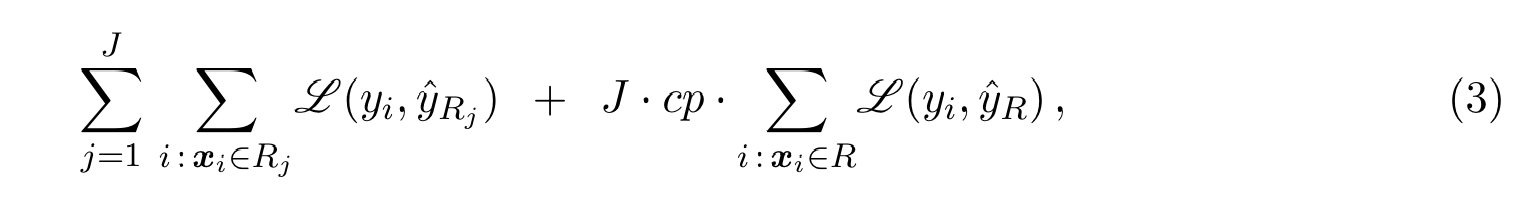

### Custom poisson deviance 
To avoid y_true==0 in the log

In [20]:
from typing import Tuple
def poisson_deviance(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    '''Calculate the Poisson deviance.'''
    y_true = dtrain.get_label()
    y_pred = predt #np.exp(predt)
    e = np.exp(-80)  # to avoid y_true==0 for claims
    deviance = 2 * np.sum(y_true * np.log((y_true + e) / y_pred) - (y_true - y_pred))
    return 'Poisson Deviance', deviance / len(y_true)

In [21]:
params = {
    'objective': 'count:poisson',  # Poisson regression objective
    'max_depth': 6,  # Maximum depth of a tree
    'gamma': 0.1,  # Complexity penalty
    'subsample': 0.75,  # Percentage of data used to train each tree
    'learning_rate': 0.01,  # Shrinkage parameter
    'min_split_loss': 0.01,  # Enforces a stopping criterion for trees
    'eval_metric': poisson_deviance , #costume metric
    'n_estimators':1000 #represents M in our Algo 10.3
}

# Define the XGBoost regressor with the specified parameters
gbm_freq = xgb.XGBRegressor(**params)

# Fit the model on the training data
gbm_freq.fit(X_train_freq, y_train_freq)

# Make predictions on the testing data
y_pred_freq_xg = gbm_freq.predict(X_test_freq)


#on all Data prediction

y_pred_freq_final = gbm_freq.predict(X)

# Evaluate the model
mse = mean_poisson_deviance(y_test_freq, y_pred_freq_xg)
print("mean_poisson_deviance:", mse)

mean_poisson_deviance: 0.7090702768140108


### Crossvalidation comapraison between two models 

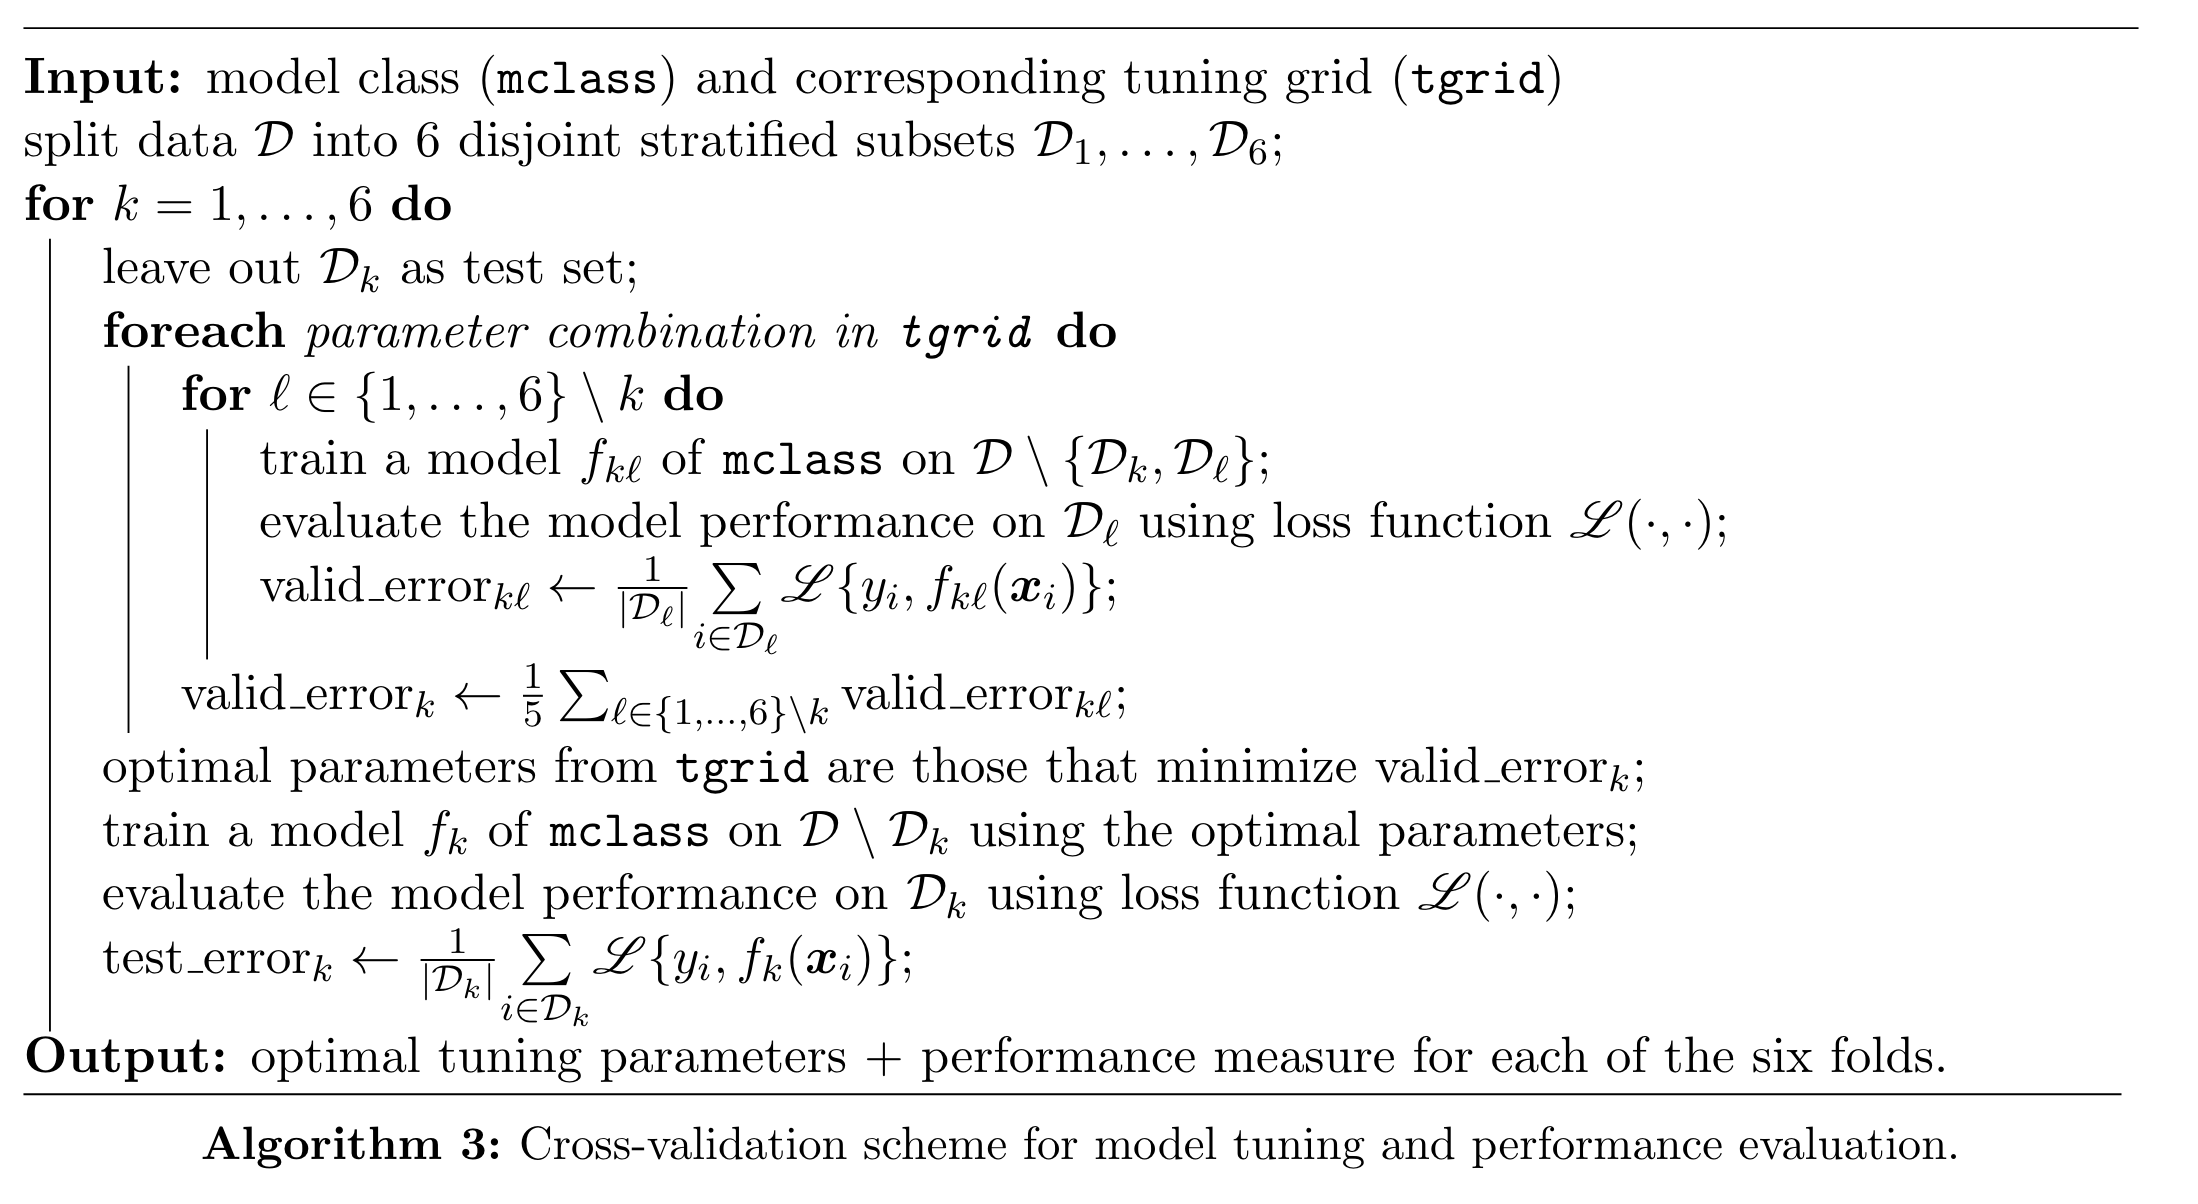

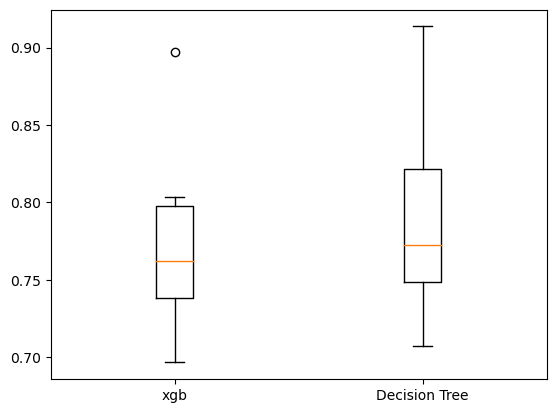

In [22]:
def poisson_deviance_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return mean_poisson_deviance(y, y_pred)

models = {"xgb": gbm_freq, 
      "Decision Tree": tree_freq}
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_freq, y_train_freq, cv=kf, scoring=poisson_deviance_scorer)
    results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.show()


Overall we can see that the xgboost performs better than decision tree. 

#### Comparing performance using unscaled data

In [23]:
poisson_dev1 = mean_poisson_deviance(y_test_freq, y_pred_freq_xg)
print("On Test data XGBoost poisson_deviance:", poisson_dev1)
poisson_dev1 = mean_poisson_deviance(y_test_freq, test_Tree_predictions)
print("On Test data tree poisson_deviance:", poisson_dev1)

On Test data XGBoost poisson_deviance: 0.7090702768140108
On Test data tree poisson_deviance: 0.7260394048677671


### Tuning and hyper-parameters Gridsearch CV

In [25]:
# Get the best parameters and best score
best_params = xgb_cv.best_params_
best_score = xgb_cv.best_score_  # Take the negative of the score


print("Best Parameters:", best_params)
print("Best Poisson Deviance Score:", best_score)

NameError: name 'xgb_cv' is not defined

# Severity modeling

We first subset the data keeping only the observations with actual claims
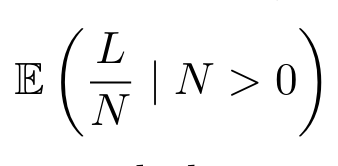

In [26]:

# subset the data based on claim amount
mtpl1_sev = mtpl1.query('nbrtotc >= 1 ')
mtpl1_sev.shape

###########################

X_sev = mtpl1_sev.drop(columns=['nbrtotc','chargtot','duree', 'nbrtotan']) # 
#y = mtpl1_sev['nbrtotc']

# claim frequency (nclaims/expo) as target

y_mtpl_sev = np.array(mtpl1_sev.chargtot/mtpl1_sev.nbrtotc)
y_mtpl_sev_log = np.log(y_mtpl_sev)
# exposure as weights
w_mtpl_sev = np.array(mtpl1_sev.duree)
# cols to retain as features
sev_cols = X_sev.columns
# subset the data
X_mtpl_sev = X_sev[feat_cols]




## to avoid deviding by 0
mask = mtpl1.nbrtotc != 0

# Perform division only where the mask is True, else assign zero
y_mtpl_sev1 = np.where(mask, mtpl1.chargtot / mtpl1.nbrtotc, 0)


# print the shape

print(y_mtpl_sev1.shape)


(163657,)


### Train and test split

In [27]:
# Split data into training and testing sets

X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(X_mtpl_sev, y_mtpl_sev, test_size=0.2, random_state=42)




### Decision tree SEVERITY
#### (I couldn't adapt gamma in Decision tree, and creating a custom is very difficult)
##### So this is my second best option
##### Fit a MSE regression tree of depth one to the log-transformed target

In [28]:
y_train_sev_log = np.log(y_train_sev)
y_train_sev_log

array([4.19809495, 4.2538661 , 6.66972327, ..., 5.04587155, 6.91616309,
       5.37511561])

In [29]:
tree_sev = DecisionTreeRegressor(criterion='squared_error', max_depth=10, min_samples_split=10000, min_samples_leaf=5000)
tree_sev.fit(X_mtpl_sev, y_mtpl_sev_log, w_mtpl_sev) # we apply sample_weight=w_mtpl_sev because we want value the data with higher duree


tree_sev

DecisionTreeRegressor(max_depth=10, min_samples_leaf=5000,
                      min_samples_split=10000)

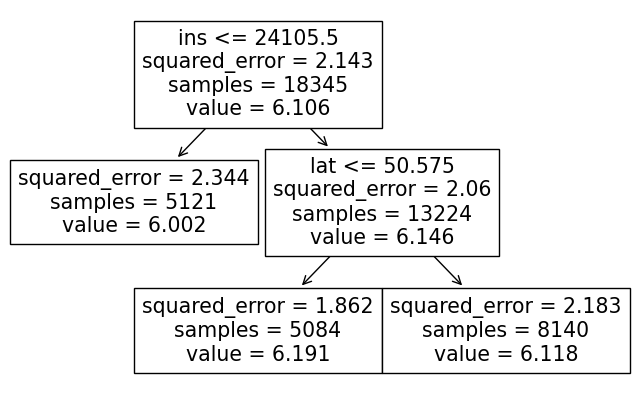

In [30]:
# plot the tree structure
plt.figure(figsize=(8, 5), dpi=100)
plot_tree(tree_sev, feature_names=sev_cols);

##### We can observe that the root node indeed predicts the weighted claim severity on the log scale for the entire portfolio:

In [31]:
# weighted mean of the protfolio log severity
np.sum(w_mtpl_sev * y_mtpl_sev_log) / np.sum(w_mtpl_sev)

6.106447420261212

How about the claim severity predictions on the actual or non-log scale? When we exponentiate the prediction result of the root node, we notice we are closer to the empirical median as to the mean severity:

In [32]:
b = np.sum(w_mtpl_sev * y_mtpl_sev_log) / np.sum(w_mtpl_sev)
# exponent of the root node prediction
print(np.exp(b))
# overall mean
print(np.mean(mtpl_sev.chargtot))
# overall median
print(np.median(mtpl_sev.chargtot))

448.7416894328062
1794.030076789152
574.51803301


::This can be explained in two different ways:
1. The mean of the log-normal distribution is equal to $\exp(\mu + \sigma^2/2)$ and we are calculating $\exp(\mu)$, which is the median. But unlike GLMs, we do not get a proper estimate for $\sigma$ in a decision tree, only an estimate for $\mu$.
2. The exponential of an average is not equal to the average of an exponential: $\exp(1/n\sum_1^n x_i) \neq 1/n \sum_i^n\exp(x_i)$, and by exponentiating after the root node prediction we are doing the first, while we should be doing the latter.

##### Evaluation on train data

In [33]:

train_predictions = tree_sev.predict(X_train_sev)

# Calculate poisson_deviance on the training set
#exposure = mtpl1['duree']
gamma_deviance = mean_gamma_deviance(y_train_sev, train_predictions)
print("Training poisson_deviance:", gamma_deviance)


Training poisson_deviance: 519.1068496647242


##### Evaluation on test data

In [34]:
test_predictions = tree_sev.predict(X_test_sev)
print(len(test_predictions))
gamma_deviance = mean_gamma_deviance(y_test_sev, test_predictions)
print("Training poisson_deviance:", gamma_deviance)

3669
Training poisson_deviance: 533.912607494751


## Gradient boosting machine SEVERITY

In [35]:
params = {
    'objective': 'reg:gamma',  # gamma regression objective
    'max_depth': 6,  # Maximum depth of a tree
    'gamma': 0.1,  # Complexity penalty
    'subsample': 0.75,  # Percentage of data used to train each tree
    'learning_rate': 0.01,  # Shrinkage parameter
    'min_split_loss': 0.01,  # Enforces a stopping criterion for trees
    'eval_metric': 'gamma-deviance' , 
    'n_estimators':1000 #represents M in our Algo 10.3
}

# Define the XGBoost regressor with the specified parameters
gbm_sev = xgb.XGBRegressor(**params)

# Fit the model on the training data
gbm_sev.fit(X_train_sev, y_train_sev)

# Make predictions on the testing data
y_pred_sev_xg = gbm_sev.predict(X_test_sev)


#on all Data prediction

y_pred_sev_final = gbm_sev.predict(X)

# Evaluate the model
mse = mean_gamma_deviance(y_test_sev, y_pred_sev_xg)
print("mean_gamma_deviance:", mse)

mean_gamma_deviance: 2.9300655637716564


In [36]:
y_pred_sev_final

array([ 908.18024, 1331.2091 ,  983.4887 , ...,  320.9617 ,  954.9168 ,
        822.96484], dtype=float32)

Unfortunately, there is not an ideal way to model claim severities with a decision tree in scikit-learn because the distributional loss functions are not implemented

### Grid search cross-validation

### Gradient boosting machine

### Grid search cross-validation

## Tariffs using Xgboost results 
Now all ML models are fit, we can start analyzing them. To streamline this process, we define a predict function `predict_model` that can be applied to the different models in a uniform way:


In [37]:
Price = y_pred_sev_final * y_pred_freq_final
price_df = pd.DataFrame({'Losses': Price})

# Concatenate X and price_df along the columns axis (axis=1)
Tarif = pd.concat([X, price_df], axis=1)
Tarif

,ageph,codposs,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,ins,commune,lat,long,Losses
0,64,1000,1,0,1,1,0,0,0,1,0,21004,85,50.833333,4.350000,116.592491
1,28,1000,2,0,1,2,0,0,0,0,0,21004,85,50.833333,4.350000,2759.180908
2,58,1000,3,0,1,3,0,0,0,0,1,21004,85,50.833333,4.350000,231.050781
3,62,1000,3,0,1,1,0,0,0,1,1,21004,85,50.833333,4.350000,119.628510
4,41,1000,2,0,1,12,0,0,0,0,0,21004,85,50.833333,4.350000,339.823700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,76,3320,2,1,1,1,0,0,0,0,1,24041,232,50.766667,4.883333,146.750137
163653,42,4770,3,1,0,1,0,0,0,0,1,63001,9,50.350000,6.166667,161.092545
163654,48,4770,3,1,1,12,0,0,0,0,1,63001,9,50.350000,6.166667,60.552979
163655,27,4770,2,1,1,2,0,0,0,0,1,63001,9,50.350000,6.166667,228.388062


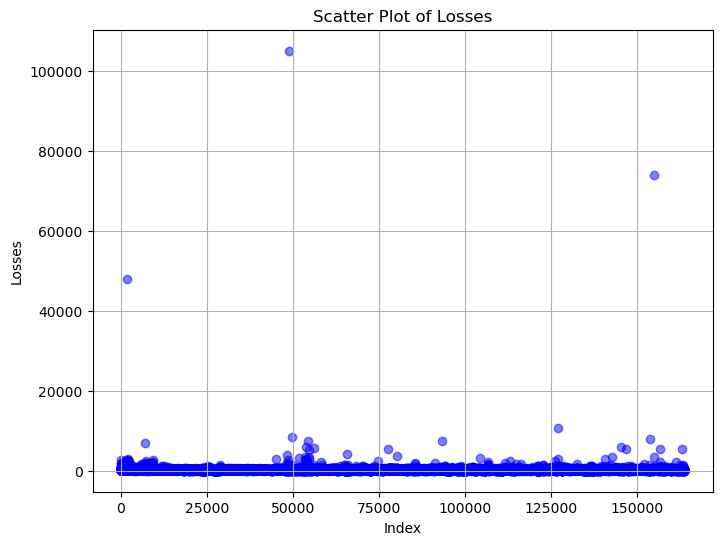

In [38]:
# Assuming 'concatenated_df' is your DataFrame and 'column_name' is the name of the column you want to plot
column_name = 'Losses'

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Tarif.index, Tarif[column_name], c='blue', marker='o', alpha=0.5)
plt.xlabel('Index')  # Assuming you want the index on the x-axis
plt.ylabel(column_name)  # Name of the column on the y-axis
plt.title(f'Scatter Plot of {column_name}')
plt.grid(True)
plt.show()

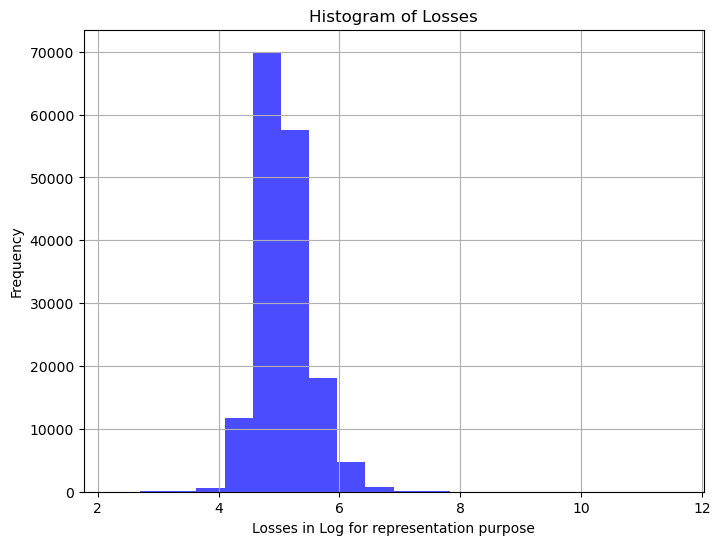

In [39]:
# Histogram
plt.figure(figsize=(8, 6))
plt.hist(np.log(Tarif[column_name]), bins=20, color='blue', alpha=0.7)
plt.xlabel('Losses in Log for representation purpose')
plt.ylabel('Frequency')
plt.title(f'Histogram of {column_name}')
plt.grid(True)
plt.show()


#### In Loss model course we have seen and proved that a Poisson–Gamma Mixture Is Negative-Binomially Distributed

This is why we decided to fit the very disperse premiums assuming a neg binomial distribution.


In [40]:
import statsmodels.api as sm

y_price=Tarif['Losses']

# Fit a negative binomial regression model
model = sm.GLM(y_price, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Losses   No. Observations:               163657
Model:                            GLM   Df Residuals:                   163642
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0073e+06
Date:                Sat, 18 May 2024   Deviance:                       23536.
Time:                        14:34:30   Pearson chi2:                 4.06e+05
No. Iterations:                    10   Pseudo R-squ. (CS):            0.07519
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ageph         -0.0154      0.000    -88.869      0.0

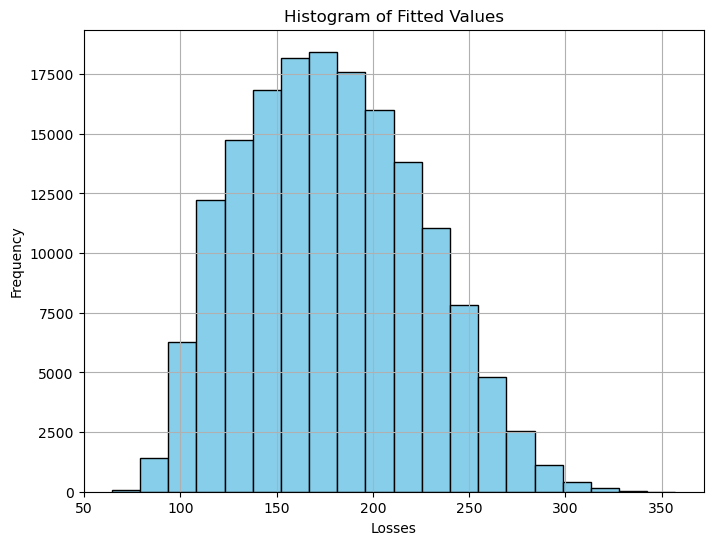

In [41]:
# Get the fitted values
fitted_values = result.fittedvalues

# Plot a histogram of the fitted values
plt.figure(figsize=(8, 6))
plt.hist(fitted_values, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.title('Histogram of Fitted Values')
plt.grid(True)
plt.show()

#### Loading for expenses and profit 

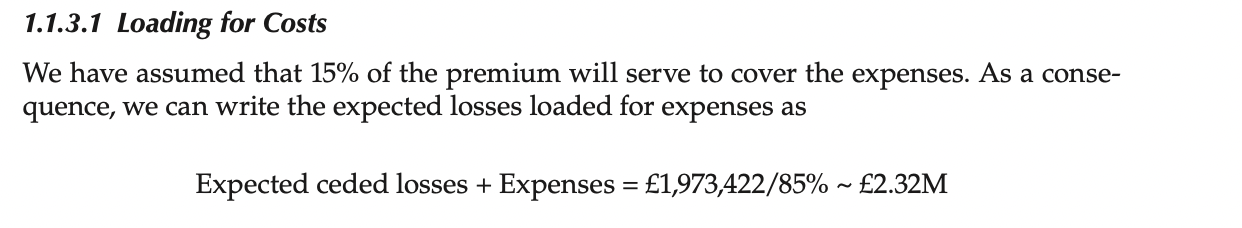

In [69]:
pred_loss = result.predict(X)
pred_loss = pred_loss*mtpl_orig['duree']
pred_Price_df = pd.DataFrame({'Expected ceded losses': pred_loss})
# Concatenate X and price_df along the columns axis (axis=1)
Expenses = 0.85
Profit = 0.9
return_on_invest = 0.03
Technical_premium = ((pred_loss/Expenses)/ (return_on_invest+1))/Profit
Technical_premium = pd.DataFrame({'Technical premium': Technical_premium})
Tarif2 = pd.concat([mtpl_orig, pred_Price_df,Technical_premium], axis=1)
Tarif2


,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,Expected ceded losses,Technical premium
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110,136.894616,173.735155
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110,12.629773,16.028648
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66,69.637416,88.377962
3,37,1030,0.169863,-1.772763,0,0.000000,0.000000,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110,25.146119,31.913344
4,29,1030,1.000000,0.000000,0,0.000000,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66,247.442318,314.033020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,50,9960,1.000000,0.000000,0,0.000000,0.000000,2-5,Male,Petrol,Once,Private,No,No,MTPL+,<66,108.658792,137.900619
163653,86,9960,1.000000,0.000000,0,0.000000,0.000000,6-10,Male,Petrol,Once,Private,No,No,MTPL,<66,176.736367,224.298962
163654,64,9960,1.000000,0.000000,0,0.000000,0.000000,2-5,Male,Petrol,Twice,Private,No,No,MTPL,<66,170.343683,216.185904
163655,58,9970,1.000000,0.000000,1,1.000000,3177.994988,>10,Male,Petrol,Once,Private,Yes,No,MTPL,<66,201.499612,255.726394


## Model interpretation

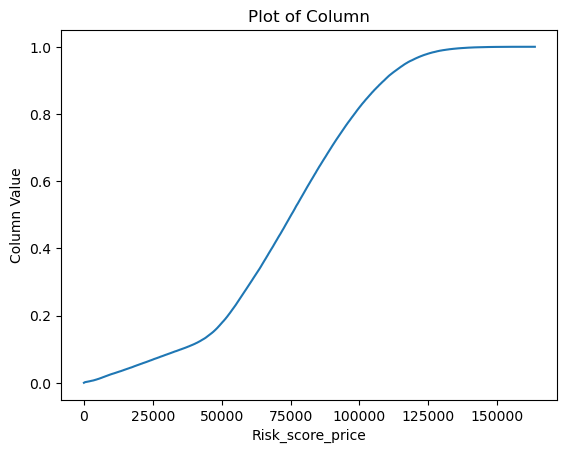

In [76]:
import scipy.stats as stats

def calculate_risk_score(data):
    ecdf = stats.cumfreq(data, numbins=len(data))
    ecdf_values = ecdf.cumcount / len(data)
    return ecdf_values

Risk_score_price = calculate_risk_score(Tarif2['Technical premium'])

#Sort Tarif2

sorted_Tarif2 = Tarif2.sort_values(by='Technical premium', ascending=True)


Risk_score_price = pd.DataFrame({'Risk_score_price': Risk_score_price})
# Concatenate X and price_df along the columns axis (axis=1)
sorted_Tarif2 = pd.concat([sorted_Tarif2.reset_index(drop=True), Risk_score_price.reset_index(drop=True)], axis=1)

plt.plot(sorted_Tarif2.index, sorted_Tarif2['Risk_score_price'])
plt.xlabel('Risk_score_price')
plt.ylabel('Column Value')
plt.title('Plot of Column')
plt.show()

### Variable importance

In [88]:
# obtain the feature importance values
tree_freq.feature_importances_

array([0.70178545, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.09268955, 0.03095419, 0.11559498, 0.05897583])

In [89]:
# collect the feature names and importance scores
tree_freq_fi = pd.DataFrame({'feature':tree_freq.feature_names_in_, 'importance':tree_freq.feature_importances_}).sort_values('importance', ascending=False)
# inspect the results
tree_freq_fi

,feature,importance
0,ageph,0.701785
13,lat,0.115595
11,ins,0.092690
14,long,0.058976
12,commune,0.030954
1,codposs,0.000000
2,agecar,0.000000
3,sexp,0.000000
4,fuelc,0.000000
5,split,0.000000


In [90]:
# collect the feature names and importance scores
tree_sev_fi = pd.DataFrame({'feature':tree_sev.feature_names_in_, 'importance':tree_sev.feature_importances_}).sort_values('importance', ascending=False)
# inspect the results
tree_sev_fi

,feature,importance
11,ins,0.817845
13,lat,0.182155
0,ageph,0.000000
1,codposs,0.000000
2,agecar,0.000000
3,sexp,0.000000
4,fuelc,0.000000
5,split,0.000000
6,usec,0.000000
7,fleetc,0.000000


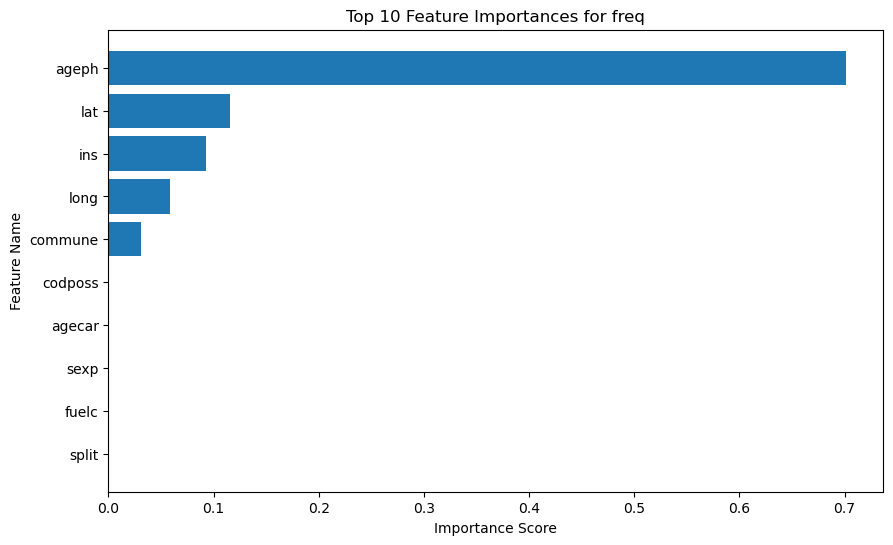

In [101]:
tree_freq_fi = pd.DataFrame({'feature': tree_freq.feature_names_in_, 'importance': tree_freq.feature_importances_})
tree_freq_fi = tree_freq_fi.sort_values('importance', ascending=False)

# Plot feature importance as box plots for the top N features
top_n = 10  # Specify the number of top features to plot
top_n_features = tree_freq_fi['feature'].head(top_n)
top_n_importances = tree_freq_fi['importance'].head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_n_features, top_n_importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances for freq')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()


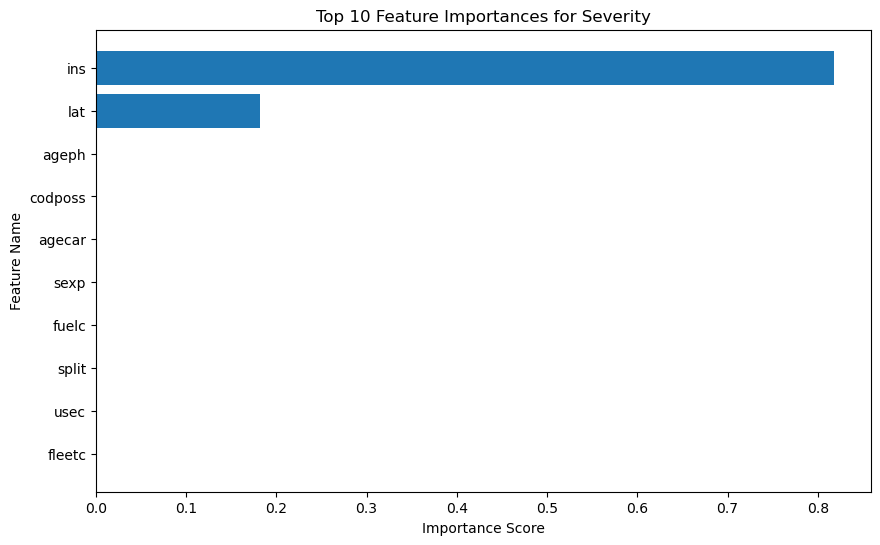

In [102]:
tree_freq_fi = pd.DataFrame({'feature': tree_sev.feature_names_in_, 'importance': tree_sev.feature_importances_})
tree_freq_fi = tree_freq_fi.sort_values('importance', ascending=False)

# Plot feature importance as box plots for the top N features
top_n = 10  # Specify the number of top features to plot
top_n_features = tree_freq_fi['feature'].head(top_n)
top_n_importances = tree_freq_fi['importance'].head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_n_features, top_n_importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances for Severity')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()


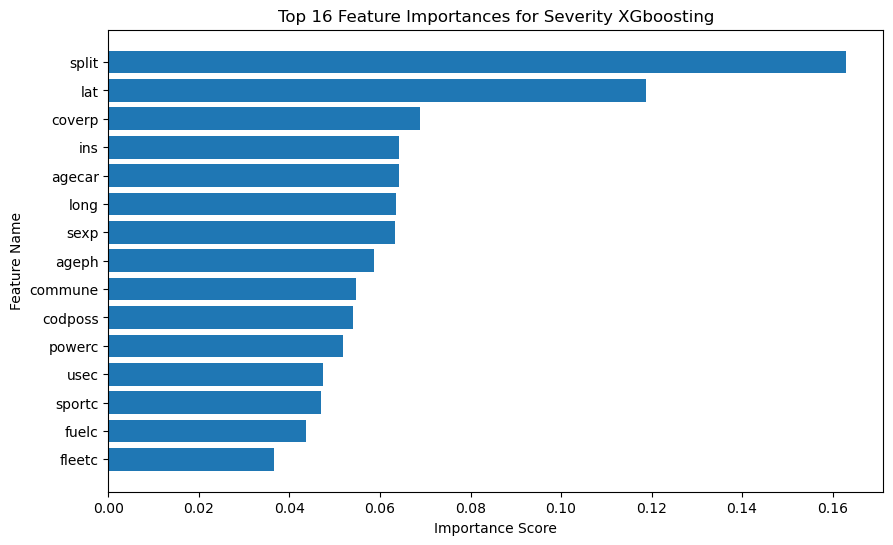

In [98]:
tree_freq_fi = pd.DataFrame({'feature': gbm_sev.feature_names_in_, 'importance': gbm_sev.feature_importances_})
tree_freq_fi = tree_freq_fi.sort_values('importance', ascending=False)

# Plot feature importance as box plots for the top N features
top_n = 16 # Specify the number of top features to plot
top_n_features = tree_freq_fi['feature'].head(top_n)
top_n_importances = tree_freq_fi['importance'].head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_n_features, top_n_importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances for Severity XGboosting')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()


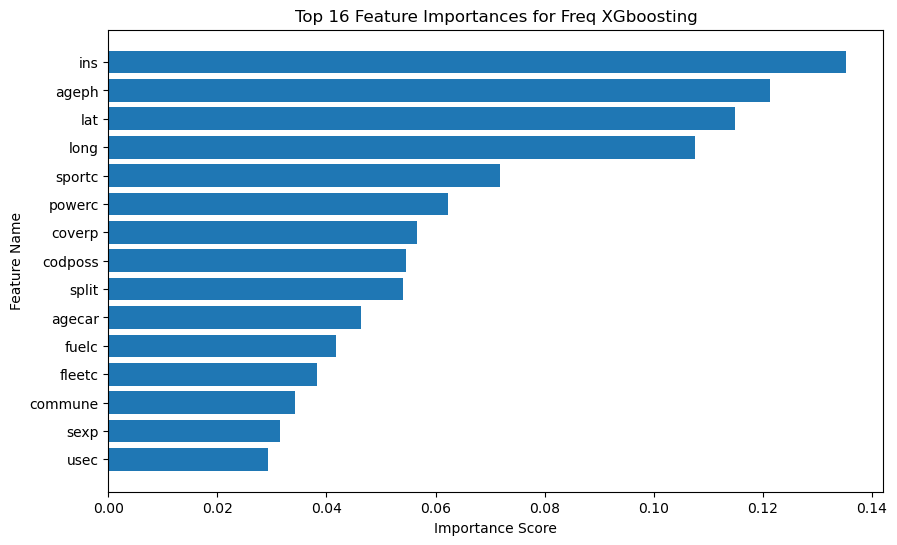

In [100]:
tree_freq_fi = pd.DataFrame({'feature': gbm_freq.feature_names_in_, 'importance': gbm_freq.feature_importances_})
tree_freq_fi = tree_freq_fi.sort_values('importance', ascending=False)

# Plot feature importance as box plots for the top N features
top_n = 16  # Specify the number of top features to plot
top_n_features = tree_freq_fi['feature'].head(top_n)
top_n_importances = tree_freq_fi['importance'].head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_n_features, top_n_importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances for Freq XGboosting')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()

Figure 7: Partial dependence plot to visualize the effect of the municipality of residence on frequency
in a GLM (top left), GAM (top right), regression tree (bottom left) and gradient boosting
machine (bottom right).

### individual conditional expectation (ICE)

### partial dependence plots (PDPs)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/inspection/_plot/partial_dependence.py:1110: UserWarning: Attempting to set identical bottom == top == 6.106447420261244 results in singular transformations; automatically expanding.
  ax.set_ylim(self.pdp_lim[1])


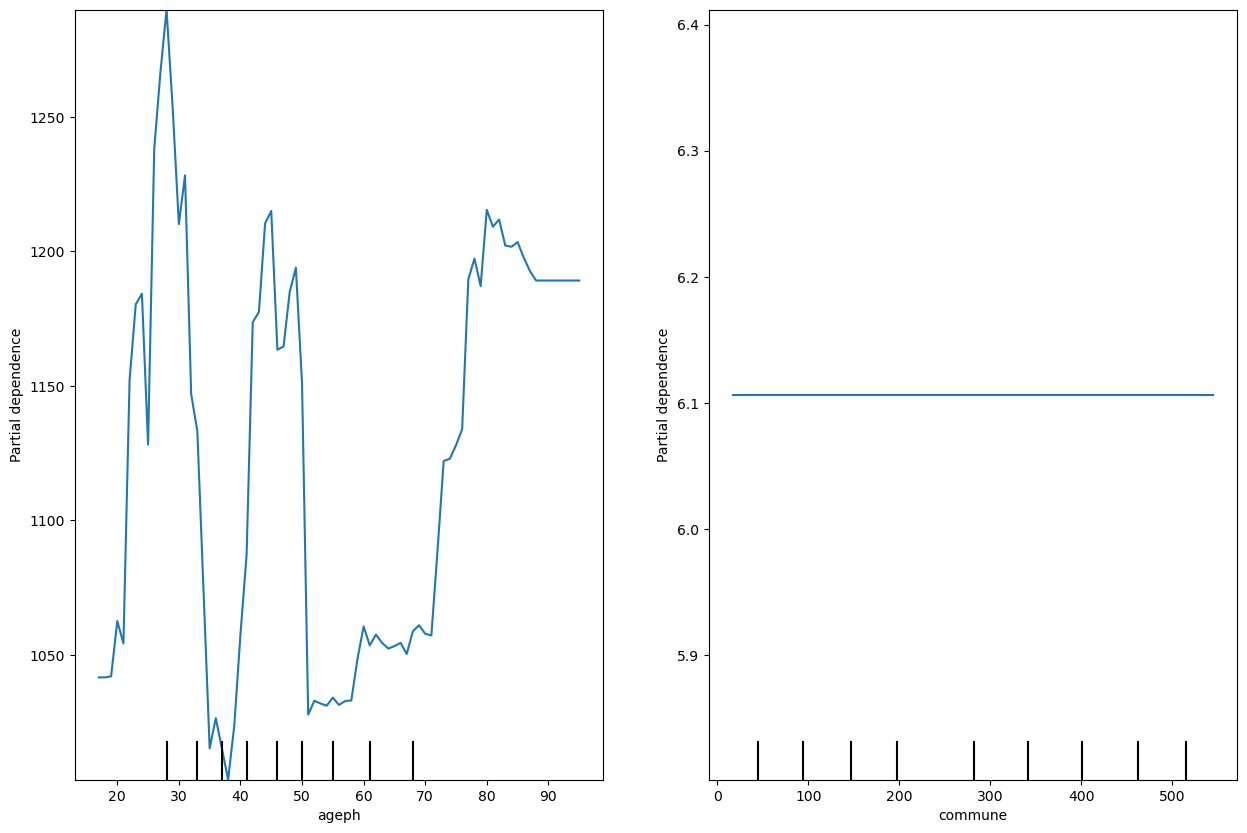

In [108]:
from sklearn.inspection import PartialDependenceDisplay

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
PartialDependenceDisplay.from_estimator(gbm_sev, X_mtpl_freq, features = ['ageph'],  kind='average', ax=axs[0])

PartialDependenceDisplay.from_estimator(tree_sev, X_mtpl_freq, features = ['powerc'],  kind='average', ax=axs[1])




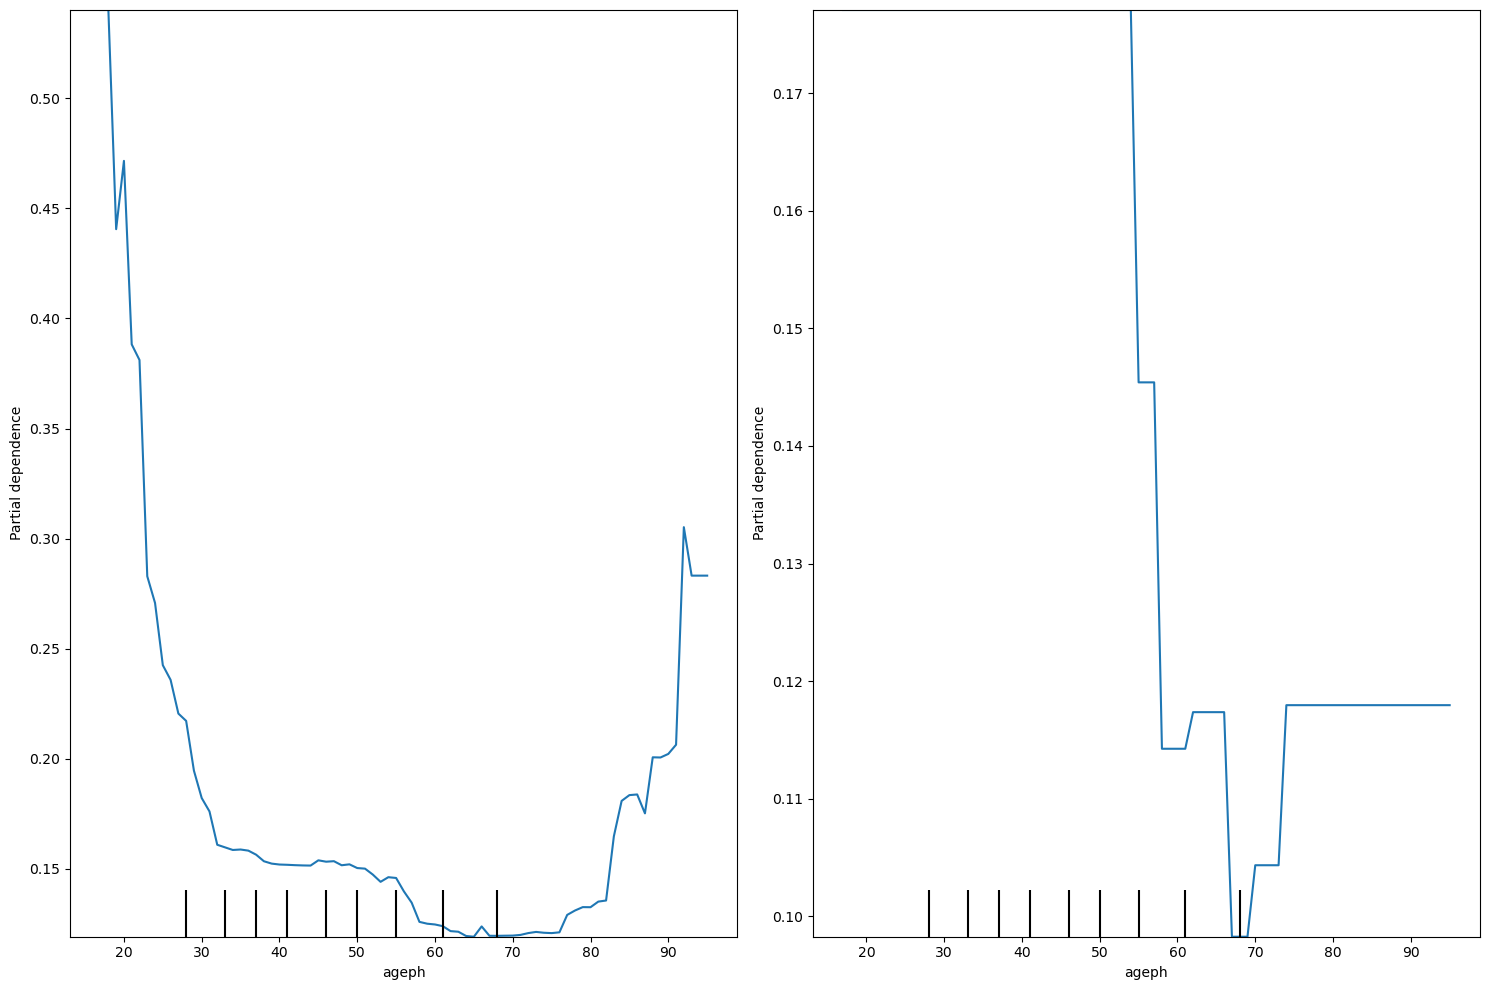

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
PartialDependenceDisplay.from_estimator(gbm_freq, X_mtpl_freq, features = ['ageph'],  kind='average', ax=axs[0])

PartialDependenceDisplay.from_estimator(tree_freq, X_mtpl_freq, features = ['ageph'],  kind='average', ax=axs[1])

plt.tight_layout()
plt.show()

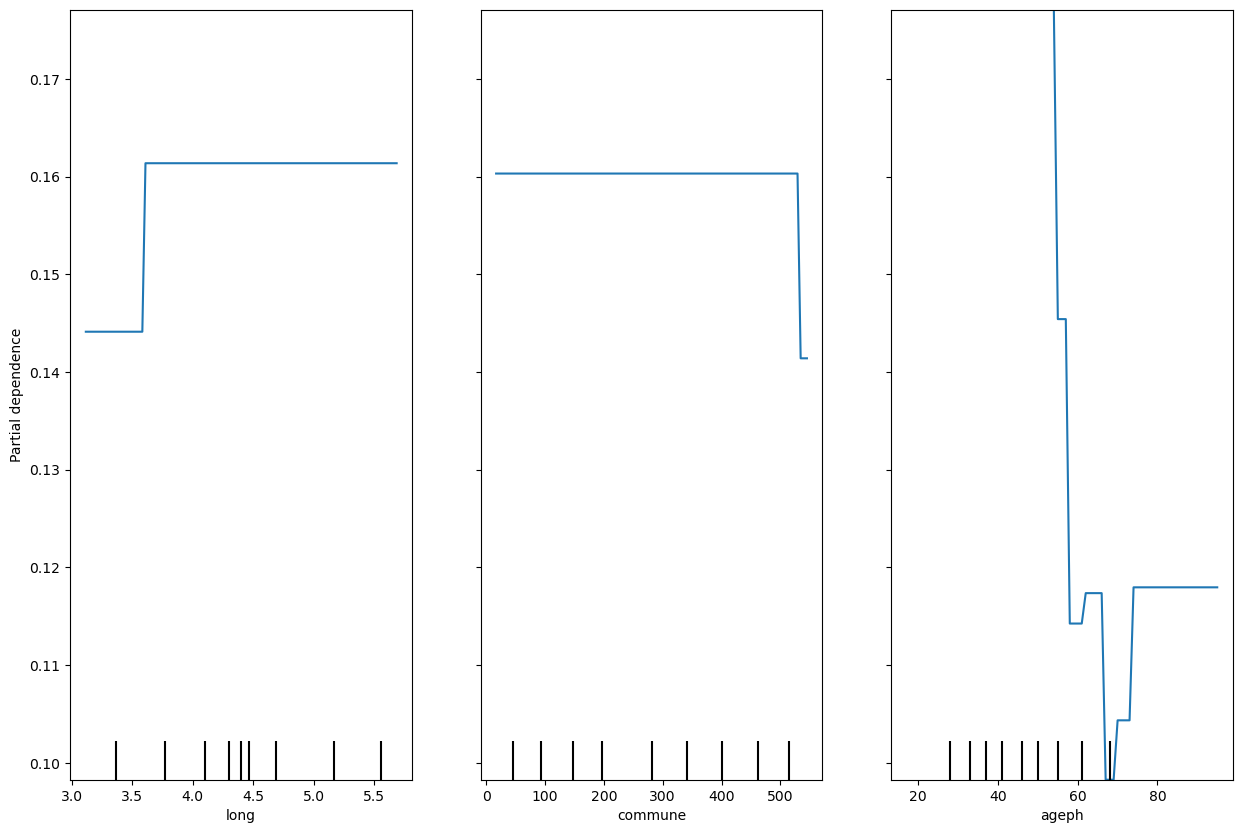

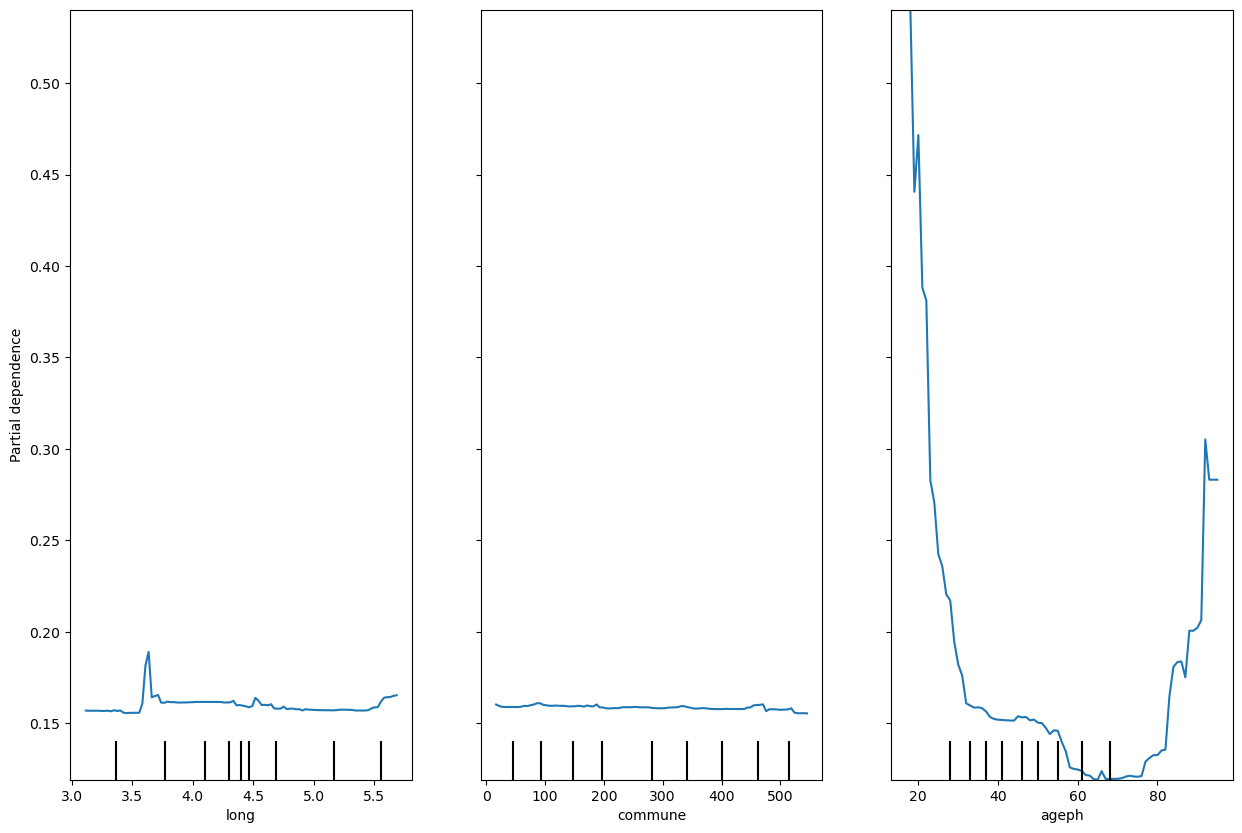

In [116]:
# create pdps for a couple of features
fig, ax = plt.subplots(figsize=(15, 10))

PartialDependenceDisplay.from_estimator(tree_freq, X_mtpl_freq, features = ['long','commune','ageph'], kind='average', ax=ax);





fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(gbm_freq, X_mtpl_freq, features = ['long','commune','ageph'], kind='average', ax=ax);

## Interaction effects


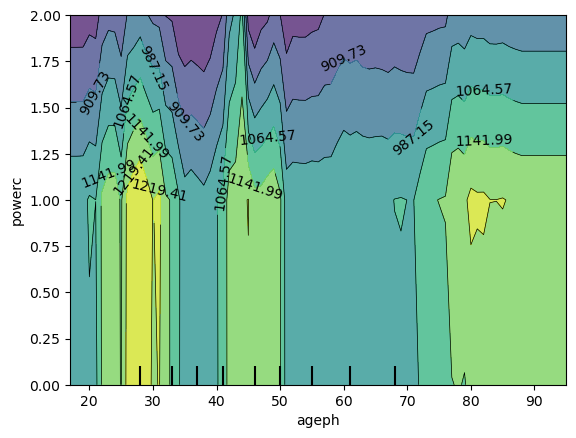

In [103]:
PartialDependenceDisplay.from_estimator(gbm_sev, X, features = [('ageph','powerc')], kind='average');

The colors in these plots represent different values of the severity, it shows the interaction between the power and age affects the prediction of severity. 

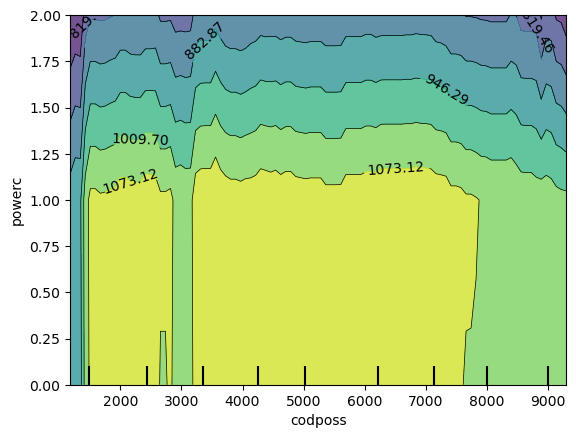

In [104]:
PartialDependenceDisplay.from_estimator(gbm_sev, X, features = [('codposs','powerc')], kind='average');

## Statistical performance
After gaining some insights from the different ML models, we now put focus on comparing the out-of-sample performance on the test data `mtpl_tst`. We predict each ML model on the test data:


In [81]:
print('Poisson deviance in out of sample for frequency while using decision tree is  ' , mean_poisson_deviance(y_test_freq, tree_freq.predict(X_test_freq)))
print('Poisson deviance in out of sample for frequency while using XGboost is  ' , mean_poisson_deviance(y_test_freq, gbm_freq.predict(X_test_freq)))
print('Gamma deviance in out of sample for severity while using decision tree is  ' , mean_gamma_deviance(y_test_sev, np.exp(tree_sev.predict(X_test_sev))))
print('Gamma deviance in out of sample for severity while using XGboost is  ' , mean_gamma_deviance(y_test_sev, gbm_sev.predict(X_test_sev)))


Poisson deviance in out of sample for frequency while using decision tree is   0.7260394048677671
Poisson deviance in out of sample for frequency while using XGboost is   0.7090702768140108
Gamma deviance in out of sample for severity while using decision tree is   5.3754985562971855
Gamma deviance in out of sample for severity while using XGboost is   2.9300655637716564


## Economic lift

After comparing the ML models for frequency and severity, we now turn to a comparison at the premium level. We calculate the predicted premiums for the test data `mtpl_tst` by multiplying the frequency and severity:



IT got really confusing since the unseen data are diffrent for sev and freq 


#### Premuim with DT on all data

In [105]:
np.unique(np.exp(tree_sev.predict(X)))
tree_freq.predict(X)

array([0.11736045, 0.19905761, 0.11424749, ..., 0.12417133, 0.12417133,
       0.12417133])

In [87]:
Tree_Losses= (tree_freq.predict(X)) * np.exp(tree_sev.predict(X))



### Technical prem
    
pred_Price_df = pd.DataFrame({'Expected ceded losses': Tree_Losses})
# Concatenate X and price_df along the columns axis (axis=1)
Expenses = 0.85
Profit = 0.9
return_on_invest = 0.03
Technical_premium = ((Tree_Losses/Expenses)/ (return_on_invest+1))/Profit
Technical_premium = pd.DataFrame({'DT Technical premium': Technical_premium})
Premuim = pd.concat([X, pred_Price_df,Technical_premium], axis=1)
Premuim


,ageph,codposs,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,ins,commune,lat,long,Expected ceded losses,DT Technical premium
0,64,1000,1,0,1,1,0,0,0,1,0,21004,85,50.833333,4.350000,47.434591,60.200001
1,28,1000,2,0,1,2,0,0,0,0,0,21004,85,50.833333,4.350000,80.454841,102.106530
2,58,1000,3,0,1,3,0,0,0,0,1,21004,85,50.833333,4.350000,46.176399,58.603210
3,62,1000,3,0,1,1,0,0,0,1,1,21004,85,50.833333,4.350000,47.434591,60.200001
4,41,1000,2,0,1,12,0,0,0,0,0,21004,85,50.833333,4.350000,80.454841,102.106530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,76,3320,2,1,1,1,0,0,0,0,1,24041,232,50.766667,4.883333,47.674914,60.504999
163653,42,4770,3,1,0,1,0,0,0,0,1,63001,9,50.350000,6.166667,60.665298,76.991305
163654,48,4770,3,1,1,12,0,0,0,0,1,63001,9,50.350000,6.166667,60.665298,76.991305
163655,27,4770,2,1,1,2,0,0,0,0,1,63001,9,50.350000,6.166667,60.665298,76.991305


In [86]:
def Premuim_OOS (model, data ):
    if model == 'DT':
        
        y_pred_freq = tree_freq.predict(X_test_freq)
        y_pred_sev = np.exp(tree_sev.predict(X_test_freq))
        print (np.exp(tree_sev.predict(X_test_sev)))
        Losees = y_pred_sev * y_pred_freq
        
    elif model == 'Xg':
        
        y_pred_freq = gbm_freq.predict(X_test_freq)
        y_pred_sev = gbm_sev.predict(X_test_freq)
        Losees = y_pred_freq * y_pred_sev
        
        Losees = result.predict(X_test_freq) #fitted with neg binomia 
        
    ### Technical prem
    
    pred_Price_df = pd.DataFrame({'Expected ceded losses': Losees})
    # Concatenate X and price_df along the columns axis (axis=1)
    Expenses = 0.85
    Profit = 0.9
    return_on_invest = 0.03
    Technical_premium = ((pred_loss/Expenses)/ (return_on_invest+1))/Profit
    Technical_premium = pd.DataFrame({'Technical premium': Technical_premium})
    Premuim = pd.concat([X_test_freq, pred_Price_df,Technical_premium], axis=1)
    
    
    return Premuim

uu = Premuim_OOS('DT',  X_test_freq)       
    
    
uu   

    
    

[453.92390055 453.92390055 453.92390055 ... 404.17867496 453.92390055
 404.17867496]


,ageph,codposs,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,ins,commune,lat,long,Expected ceded losses,Technical premium
149186,65.0,9060.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,43018.0,568.0,51.200000,3.800000,NaN,140.725387
78765,39.0,9000.0,1.0,1.0,1.0,12.0,0.0,0.0,0.0,2.0,1.0,44021.0,185.0,51.050000,3.716667,NaN,226.398328
92058,57.0,3500.0,3.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,71022.0,211.0,50.916667,5.333333,NaN,178.589135
33852,31.0,3700.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,73083.0,508.0,50.766667,5.450000,NaN,283.347816
45462,60.0,5000.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,92094.0,375.0,50.450000,4.850000,NaN,185.290729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,306.251098
163652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.900619
163654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.185904
163655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.726394


#### Premuim with XG on OOS

In [150]:
XG_Losses= (gbm_freq.predict(X_test_freq)) * gbm_sev.predict(X_test_freq)

### Technical prem
    
pred_Price_df = pd.DataFrame({'Expected ceded losses': XG_Losses})
# Concatenate X and price_df along the columns axis (axis=1)
Expenses = 0.85
Profit = 0.9
return_on_invest = 0.03
Technical_premium = ((XG_Losses/Expenses)/ (return_on_invest+1))/Profit
Technical_premium = pd.DataFrame({'DT Technical premium': Technical_premium})
Premuim = pd.concat([X_test_freq, pred_Price_df,Technical_premium], axis=1)
Premuim



,ageph,codposs,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,ins,commune,lat,long,Expected ceded losses,DT Technical premium
149186,65.0,9060.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,43018.0,568.0,51.200000,3.800000,NaN,NaN
78765,39.0,9000.0,1.0,1.0,1.0,12.0,0.0,0.0,0.0,2.0,1.0,44021.0,185.0,51.050000,3.716667,NaN,NaN
92058,57.0,3500.0,3.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,71022.0,211.0,50.916667,5.333333,NaN,NaN
33852,31.0,3700.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,73083.0,508.0,50.766667,5.450000,NaN,NaN
45462,60.0,5000.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,92094.0,375.0,50.450000,4.850000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.394623,188.330017
32728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,339.810944,431.259552
32729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.338593,167.953033
32730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174.010895,220.840012


In [151]:
X_test_freq

,ageph,codposs,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,ins,commune,lat,long
149186,65,9060,2,1,1,2,0,0,0,0,1,43018,568,51.200000,3.800000
78765,39,9000,1,1,1,12,0,0,0,2,1,44021,185,51.050000,3.716667
92058,57,3500,3,1,0,2,0,0,0,0,1,71022,211,50.916667,5.333333
33852,31,3700,2,0,0,2,0,0,0,1,1,73083,508,50.766667,5.450000
45462,60,5000,2,1,1,2,0,0,0,0,0,92094,375,50.450000,4.850000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140392,25,8210,3,1,1,3,0,0,0,0,1,31040,566,51.133333,3.133333
44118,27,5000,2,0,1,2,0,0,0,0,1,92094,375,50.450000,4.850000
83851,55,9470,3,1,0,1,0,0,0,0,0,41011,119,50.883333,4.083333
39176,65,4100,1,0,1,3,0,0,0,2,1,62096,462,50.600000,5.500000


In [ ]:
# Calculate the Poisson deviance for the frequency models
poisson_deviance_freq = oos_pred.filter(like='_freq').apply(
    lambda x: dev_poiss(mtpl1['nbrtotc'], x * mtpl1['duree'])
)

# Calculate the Gamma deviance for the severity models
gamma_deviance_sev = oos_pred.filter(like='_sev').apply(
    lambda x: dev_gamma(mtpl1['chargtot'], x, mtpl1['nbrtotc'])
)
print (poisson_deviance_freq, gamma_deviance_sev)

In [ ]:
def loss_ratio_lift(bench, comp, ngroups, pred_df, true_values):

    # Calculate loss ratios for both models
    bench_loss_ratio = pred_df[bench] / true_values
    comp_loss_ratio = pred_df[comp] / true_values

    # Calculate bins for grouping predictions
    bin_edges = np.linspace(0, 1, ngroups + 1)
    bins = pd.cut(bench_loss_ratio, bins=bin_edges, labels=False, include_lowest=True)

    # Calculate loss ratio lift for each group
    lrl = {}
    for group in range(ngroups):
        group_indices = bins[bins == group].index
        mean_bench_loss_ratio = bench_loss_ratio.iloc[group_indices].mean()
        mean_comp_loss_ratio = comp_loss_ratio.iloc[group_indices].mean()
        lrl[group] = mean_comp_loss_ratio - mean_bench_loss_ratio

    # Create DataFrame from dictionary
    lrl_df = pd.DataFrame.from_dict(lrl, orient='index', columns=['Loss Ratio Lift'])

    return lrl_df

# Calculate loss ratio lift between tree and gbm models
lrl_gbm_tree = loss_ratio_lift('tree_freq', 'gbm_freq', 5, oos_pred, mtpl1['nbrtotc'])

# Calculate loss ratio lift between gbm and tree models
lrl_tree_gbm = loss_ratio_lift('gbm_freq', 'tree_freq', 5, oos_pred, mtpl1['nbrtotc'])

print("Loss Ratio Lift (Tree vs. GBM):\n", lrl_gbm_tree)
print("\nLoss Ratio Lift (GBM vs. Tree):\n", lrl_tree_gbm)

Plotting these results next to each other clearly shows that the GBM aligns the risk better compared to the tree:


In [ ]:
# Define the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss ratio lift for gbm/tree comparison
axes[0].bar(lrl_gbm_tree.index, lrl_gbm_tree['Loss Ratio Lift'])
axes[0].set_title('comp: gbm / bench: tree')
axes[0].set_xlabel('Group')
axes[0].set_ylabel('Loss Ratio Lift')

# Plot loss ratio lift for tree/gbm comparison
axes[1].bar(lrl_tree_gbm.index, lrl_tree_gbm['Loss Ratio Lift'])
axes[1].set_title('comp: tree / bench: gbm')
axes[1].set_xlabel('Group')
axes[1].set_ylabel('Loss Ratio Lift')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Double lift

In [ ]:
def double_lift(data, bench, comp, ngroups):

    # Calculate relativity and sort from small to large
    data['r'] = data[comp + '_prem'] / data[bench + '_prem']
    data_sorted = data.sort_values('r')

    # Bin in groups of equal exposure
    data_sorted['bin'] = pd.cut(data_sorted['expo'].cumsum(),
                                bins=data_sorted['expo'].sum() * (list(range(ngroups + 1)) / ngroups),
                                labels=False)

    # Calculate percentage errors for both tariffs
    double_lift_df = data_sorted.groupby('bin').agg(
        r_lab=('r', lambda x: f"[{round(x.min(), 2)}, {round(x.max(), 2)}]"),
        error_comp=('comp_prem', 'mean'),
        error_bench=('bench_prem', 'mean'),
        sum_expo=('expo', 'sum')
    ).reset_index()

    double_lift_df['error_comp'] = double_lift_df['error_comp'] / double_lift_df['amount'] - 1
    double_lift_df['error_bench'] = double_lift_df['error_bench'] / double_lift_df['amount'] - 1

    return double_lift_df

In [ ]:
# Melt the DataFrame to long format
dbl_gbm_tree_melted = dbl_gbm_tree.melt(id_vars=['r_lab', 'bin', 'sum_expo'],
                                         value_name='perc_err',
                                         var_name='tariff')

# Plot the results
plt.figure(figsize=(8, 4))
sns.lineplot(data=dbl_gbm_tree_melted, x='r_lab', y='perc_err', hue='tariff', style='tariff')
plt.xlabel('Relativity Bin')
plt.ylabel('Percentage Error')
plt.title('Double Lift: GBM vs. Tree')
plt.legend(title='Tariff')
plt.show()

### Gini index

In [ ]:
from inequality import gini


In [55]:
def gini_index(loss_column, score_columns, data):
  

    gini_indices = {}

    for model in score_columns:
        # Calculate Gini index for each model
        gini_idx = gini(data[model] / data[loss_column])
        gini_indices[model] = gini_idx

    return gini_indices


In [56]:
# Calculate Gini indices for each model
gini_results = gini_index('amount', ['tree_prem', 'rf_prem', 'gbm_prem'], oos_pred)

# Convert results to DataFrame
gini_df = pd.DataFrame(gini_results, index=['gini']).T

# Add max_gini column and sort by it
gini_df['max_gini'] = gini_df.max(axis=1)
gini_df['bench'] = ['tree', 'rf', 'gbm']
gini_df_sorted = gini_df.sort_values(by='max_gini')

print(gini_df_sorted)

NameError: name 'oos_pred' is not defined

# Brouillion

In [ ]:
from sklearn import ensemble
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, train_test_split
from scipy.special import expit
# Generate data (adapted from G. Ridgeway's gbm example)
n_samples = 1000
random_state = np.random.RandomState(13)
x1 = random_state.uniform(size=n_samples)
x2 = random_state.uniform(size=n_samples)
x3 = random_state.randint(0, 4, size=n_samples)

p = expit(np.sin(3 * x1) - 4 * x2 + x3)
y = random_state.randint(1, 100, size=n_samples)

X = np.c_[x1, x2, x3]

X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=9)

# Fit classifier with out-of-bag estimates
params = {
    "n_estimators": 1200,
    "max_depth": 3,
    "subsample": 0.5,
    "learning_rate": 0.01,
    "min_samples_leaf": 1,
    "random_state": 3,
}
clf = ensemble.XGBRegressor(**params)

clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print("Accuracy: {:.4f}".format(acc))

n_estimators = params["n_estimators"]
x = np.arange(n_estimators) + 1


def heldout_score(reg, X_test, y_test):
    """Compute deviance scores on ``X_test`` and ``y_test``."""
    n_estimators = reg.get_params()['n_estimators']
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(reg.staged_predict(X_test)):
        score[i] = mean_squared_error(y_test, y_pred)
    return score

def cv_estimate(n_splits=None, params=None, X_train=None, y_train=None):
    cv = KFold(n_splits=n_splits)
    val_scores = np.zeros((params['n_estimators'],), dtype=np.float64)
    for train, test in cv.split(X_train, y_train):
        reg = xgb.XGBRegressor(**params)
        reg.fit(X_train[train], y_train[train], eval_set=[(X_train[test], y_train[test])], verbose=False)
        val_scores += heldout_score(reg, X_train[test], y_train[test])
    val_scores /= n_splits
    return val_scores


# Estimate best n_estimator using cross-validation
cv_score = cv_estimate(3)

# Compute best n_estimator for test data
test_score = heldout_score(clf, X_test, y_test)

# negative cumulative sum of oob improvements
cumsum = -np.cumsum(clf.oob_improvement_)

# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]

# min loss according to test (normalize such that first loss is 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

# min loss according to cv (normalize such that first loss is 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]

# color brew for the three curves
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))
test_color = list(map(lambda x: x / 256.0, (127, 201, 127)))
cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))

# line type for the three curves
oob_line = "dashed"
test_line = "solid"
cv_line = "dashdot"

# plot curves and vertical lines for best iterations
plt.figure(figsize=(8, 4.8))
plt.plot(x, cumsum, label="OOB loss", color=oob_color, linestyle=oob_line)
plt.plot(x, test_score, label="Test loss", color=test_color, linestyle=test_line)
plt.plot(x, cv_score, label="CV loss", color=cv_color, linestyle=cv_line)
plt.axvline(x=oob_best_iter, color=oob_color, linestyle=oob_line)
plt.axvline(x=test_best_iter, color=test_color, linestyle=test_line)
plt.axvline(x=cv_best_iter, color=cv_color, linestyle=cv_line)

# add three vertical lines to xticks
xticks = plt.xticks()
xticks_pos = np.array(
    xticks[0].tolist() + [oob_best_iter, cv_best_iter, test_best_iter]
)
xticks_label = np.array(list(map(lambda t: int(t), xticks[0])) + ["OOB", "CV", "Test"])
ind = np.argsort(xticks_pos)
xticks_pos = xticks_pos[ind]
xticks_label = xticks_label[ind]
plt.xticks(xticks_pos, xticks_label, rotation=90)

plt.legend(loc="upper center")
plt.ylabel("normalized loss")
plt.xlabel("number of iterations")

plt.show()
